In [47]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import zeros, newaxis
from evaluate_paddlepaddle import evaluate
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras
from data_loader import make_train_data, make_val_data, make_test_data, generate_dataset
from preprocessing import preprocess, marking_data   
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, TimeDistributed,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
from os import path, environ
from livelossplot import PlotLossesKeras
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
SEQ_LEN = 2
BATCH_SIZE = 256 
EPOCHS = 1000

In [67]:
# Load dataset
full_data = pd.read_csv("data/wtbdata_245days.csv")
train_data = pd.read_csv("data/train_data.csv")
submission = pd.read_csv("data/sample_submission.csv")
test_data = pd.read_csv("info/target.csv")
full_data = full_data.fillna(method = 'bfill')
train_data = train_data.fillna(method = 'bfill')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


In [68]:
# Preprocessing
full_data = preprocess(full_data)

In [52]:
full_data = marking_data(full_data, 0)

In [69]:
full_data.columns

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3',
       'Prtv', 'Patv', 'locX', 'locY', 'TimeX', 'TimeY', 'DayX', 'DayY', 'Etmp_abs', 'Wdir_adj',
       'WdirX', 'WdirY', 'NdirX', 'NdirY', 'WspdX', 'WspdY', 'WspdX_abs', 'WspdY_abs', 'TSR1',
       'TSR2', 'TSR3', 'Bspd1', 'Bspd2', 'Bspd3', 'Pab', 'RPM', 'TSR', 'Wspd_cube', 'P_max',
       'Papt', 'Patan'],
      dtype='object')

In [70]:
data = full_data.copy()

In [71]:
train_data = data[data['Day']<201]

In [72]:
features = ['TurbID','Day', 'WspdY_abs', 'Itmp', 'WdirX', 'WspdX_abs', 'Patan',
       'Prtv', 'TSR',  'Pab',
       'P_max', 'Wspd_cube', 'Wspd', 'WspdX', 'RPM',
       'Papt', 'Patv']
train_data = train_data[features]
data = data[features]

In [73]:
train_data

,TurbID,Day,WspdY_abs,Itmp,WdirX,WspdX_abs,Patan,Prtv,TSR,Pab,P_max,Wspd_cube,Wspd,WspdX,RPM,Papt,Patv
0,1,1,2.304332,41.80,0.927641,5.723544,-0.000505,-0.25,2.605089,1.00,0.857621,233.181313,6.17,6.155045,16.034441,494.660063,494.66
1,1,1,2.304332,41.80,0.927641,5.723544,-0.000505,-0.25,2.605089,1.00,0.857621,233.181313,6.17,6.155045,16.034441,494.660063,494.66
2,1,1,2.013353,41.63,0.947042,5.937955,-0.000471,-0.24,2.605089,1.00,0.900427,245.957079,6.27,6.265462,16.322087,509.760056,509.76
3,1,1,2.214711,41.52,0.938613,6.025899,-0.000479,-0.26,2.605089,1.00,0.966892,264.544863,6.42,6.419479,16.723314,542.530062,542.53
4,1,1,2.321049,41.38,0.928486,5.803036,-0.000452,-0.23,2.605089,1.00,0.892196,244.052275,6.25,6.249246,16.279842,509.360052,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721035,134,200,0.078882,10.40,-0.999868,-4.859360,-0.336971,-108.13,2.745986,0.01,0.455178,113.646913,4.86,4.843796,13.300998,327.042687,308.65
4721036,134,200,0.329748,10.33,-0.997263,-4.447793,-0.399805,-93.64,2.745986,0.01,0.352134,88.069787,4.46,4.449136,12.217265,240.572254,221.60
4721037,134,200,0.568956,10.22,-0.990913,-4.191562,-0.466906,-111.20,2.745986,0.01,0.300476,75.686746,4.23,4.229996,11.615510,247.042102,220.60
4721038,134,200,1.037789,10.10,-0.971259,-4.234689,-0.452658,-108.04,2.745986,0.01,0.329171,81.472834,4.36,4.335151,11.904266,247.028873,222.15


In [74]:
def make_test_data(data, seq_len):
    test_x, test_y = [], []
    for j in range(201, 240 - seq_len):
        test_days = np.arange(j, j+seq_len)
        label_days = np.arange(j+seq_len, j+seq_len+2)
        test_tmp = data[data.Day.isin(test_days)].drop(columns=['TurbID','Day'])
        label_tmp = data[data.Day.isin(label_days)].drop(columns=['TurbID','Day'])
        test_x.append(test_tmp)  # (720, 11) = (Tmstamp * days, n_features)
        test_y.append(label_tmp)  # (288)     = (Tmstamp * days)
    test_x, test_y = np.array(test_x, dtype=np.float32), np.array(test_y, dtype=np.float32)
    return np.array(test_x, dtype=np.float32), np.array(test_y, dtype=np.float32)

In [75]:
# Split data

train_x, train_y = make_train_data(train_data, SEQ_LEN)
# val_x,   val_y   = make_val_data(data, SEQ_LEN)
test_x, test_y   = make_test_data(data, SEQ_LEN)
# val_x,   val_y   = val_x.reshape(-1, *train_x.shape[1:]), val_y.reshape(-1, train_y.shape[1])
test_x, test_y   = test_x.reshape(-1, *train_x.shape[1:]),test_y.reshape(-1, *train_y.shape[1:])
print("Train data(X, y):", train_x.shape, train_y.shape)
# print("Val data(X, y):", val_x.shape, val_y.shape)
print("Test data(X, y):", test_x.shape, test_y.shape)

100%|██████████| 134/134 [01:10<00:00,  1.90it/s]


Train data(X, y): (26264, 288, 15) (26264, 288, 15)
Test data(X, y): (4958, 288, 15) (4958, 288, 15)


In [76]:
scaler = MinMaxScaler()
scaler.fit(train_data.iloc[:,2:])
train_x_scaled = scaler.transform(train_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
train_y_scaled = scaler.transform(train_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_x_scaled = scaler.transform(test_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_y_scaled = scaler.transform(test_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
print("Train data(X, y):", train_x_scaled.shape, train_y_scaled.shape)
print("Test data(X, y):", test_x_scaled.shape, test_y_scaled.shape)

Train data(X, y): (26264, 288, 15) (26264, 288, 15)
Test data(X, y): (4958, 288, 15) (4958, 288, 15)


In [77]:
# Generate dataset
train_ds = generate_dataset(train_x, train_y, batch_size=BATCH_SIZE)

In [78]:
test_ds = generate_dataset(test_x, test_y, batch_size=BATCH_SIZE)

In [79]:
model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(train_x.shape[1],train_x.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(Bidirectional(GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(RepeatVector(train_y.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
# model.add(RepeatVector(train_y.shape[1], name='Repeat-Vector-Layer2')) # Repeat Vector
model.add(TimeDistributed(Dense(units=train_y.shape[2], activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

In [80]:
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 512)              419328    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 15)          7695      
 ed)                                                             
                                                                 
Total params: 1,609,743
Trainable params: 1,609,743
Non-t

In [81]:
##### Step 4 - Compile the model
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )

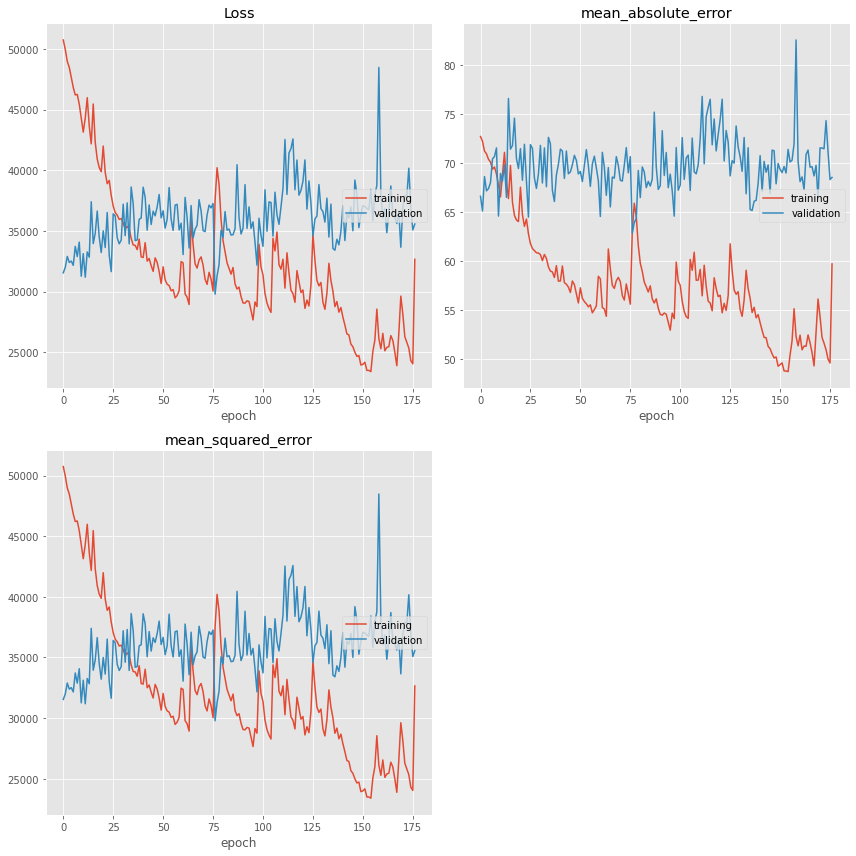

Loss
	training         	 (min: 23393.900, max: 50743.762, cur: 32653.678)
	validation       	 (min: 29782.270, max: 48481.230, cur: 35564.812)
mean_absolute_error
	training         	 (min:   48.711, max:   72.693, cur:   59.701)
	validation       	 (min:   62.844, max:   82.545, cur:   68.525)
mean_squared_error
	training         	 (min: 23393.902, max: 50743.762, cur: 32653.688)
	validation       	 (min: 29782.271, max: 48481.227, cur: 35564.816)
103/103 [==============================] - 19s 184ms/step - loss: 32653.6777 - mean_squared_error: 32653.6875 - mean_absolute_error: 59.7005 - val_loss: 35564.8125 - val_mean_squared_error: 35564.8164 - val_mean_absolute_error: 68.5252


INFO:tensorflow:Assets written to: saved_models/model_ep1000_b256_seq2_2022-07-14 14:35:42/assets


INFO:tensorflow:Assets written to: saved_models/model_ep1000_b256_seq2_2022-07-14 14:35:42/assets


In [83]:
##### Step 5 - Fit the model on the dataset
history = model.fit(train_ds, # input data, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=1000, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=[ PlotLossesKeras(),EarlyStopping(patience=100, restore_best_weights=True)], # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    #validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    validation_data=test_ds, # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=False, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                   )
now = datetime.now()
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
model.save(f'saved_models/model_ep{EPOCHS}_b{BATCH_SIZE}_seq{SEQ_LEN}_{current_time}')

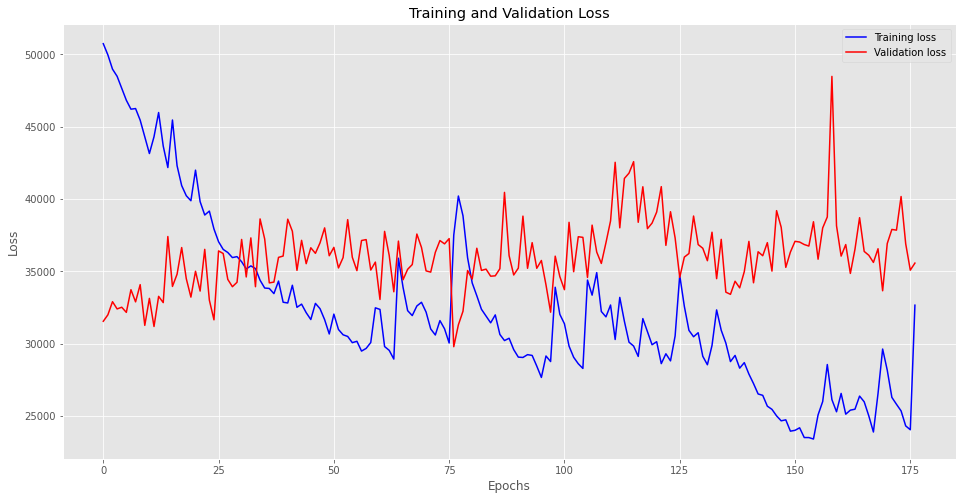

In [84]:
import matplotlib.pyplot as plt
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [85]:
##### Step 7 - Print Performance Summary
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")
#for layer in model.layers:
#    print(layer.name)
#    for item in layer.get_weights():
#        print("  ", item)
#print("")

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model.evaluate(test_x, test_y)
print("")
print('-------------------- Accuracy and Score --------------------')
test_data = data[(data['Day']>=199)&(data['Day']<=200)]
test_data.drop(['TurbID','Day'], axis = 1, inplace = True)
test_data = test_data.to_numpy().reshape(-1, *train_x.shape[1:])

submission['Patv'] =model.predict(test_data).reshape(-1,train_x.shape[2])[:,-1]
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
score = evaluate(submission)
submission.to_csv(f"output/prediction_{current_time}_score{round(score)}.csv", index=False)
print('\n --- Overall Score --- \n\t{}'.format(score))



-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 512)              419328    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 15)          7695      
 ed)                                                             
                                                                 


# Logs

## simple GRU (720, 16) in (288, 1) out

[['TurbID','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'Wspd_cos', 'Wspd', 'Wspd_cube',
       'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']]

GRU(256,input_shape=train_x[0].shape),#, return_sequences=True
    Dense(512, activation='relu'),
    Dense(288, activation='relu')

Accuracy:  52.2033%

 	 RMSE: 29.933517583828934, MAE: 23.296560652341597

 --- Overall Score --- 
	26.615039118085264
    score : 314

## Encoder-Decoder 288in 288 out

data = data[['TurbID','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'Wspd_cos', 'Wspd', 'Wspd_cube',
       'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']]

5/5 [==============================] - 0s 32ms/step

Accuracy:  71.9669%

 	 RMSE: 19.57801390209444, MAE: 14.634157679559214

 --- Overall Score --- 
	17.10608579082683
    
    score
    
    177.5901167749
    
Epoch 1/1000
103/103 [==============================] - 18s 173ms/step - loss: 20542.5469 - mean_squared_error: 20542.5488 - mean_absolute_error: 40.5084 - val_loss: 9190.2422 - val_mean_squared_error: 9190.2422 - val_mean_absolute_error: 31.9372
Epoch 2/1000
103/103 [==============================] - 17s 170ms/step - loss: 20060.1133 - mean_squared_error: 20060.1094 - mean_absolute_error: 40.0552 - val_loss: 9050.8682 - val_mean_squared_error: 9050.8672 - val_mean_absolute_error: 32.0729
Epoch 3/1000
103/103 [==============================] - 18s 171ms/step - loss: 19777.2676 - mean_squared_error: 19777.2695 - mean_absolute_error: 39.7132 - val_loss: 13408.8311 - val_mean_squared_error: 13408.8320 - val_mean_absolute_error: 38.0471
Epoch 4/1000
103/103 [==============================] - 18s 171ms/step - loss: 20310.5410 - mean_squared_error: 20310.5391 - mean_absolute_error: 40.3694 - val_loss: 8377.0322 - val_mean_squared_error: 8377.0342 - val_mean_absolute_error: 31.4856
Epoch 5/1000
103/103 [==============================] - 18s 171ms/step - loss: 20435.4707 - mean_squared_error: 20435.4746 - mean_absolute_error: 40.5617 - val_loss: 10528.1572 - val_mean_squared_error: 10528.1562 - val_mean_absolute_error: 33.1095
Epoch 6/1000
103/103 [==============================] - 18s 171ms/step - loss: 19623.9082 - mean_squared_error: 19623.9062 - mean_absolute_error: 39.6600 - val_loss: 15771.9551 - val_mean_squared_error: 15771.9531 - val_mean_absolute_error: 36.1752
Epoch 7/1000
103/103 [==============================] - 18s 171ms/step - loss: 19257.1309 - mean_squared_error: 19257.1289 - mean_absolute_error: 39.2894 - val_loss: 16201.5518 - val_mean_squared_error: 16201.5508 - val_mean_absolute_error: 38.1674
Epoch 8/1000
103/103 [==============================] - 18s 171ms/step - loss: 19339.8438 - mean_squared_error: 19339.8398 - mean_absolute_error: 39.3250 - val_loss: 11558.0186 - val_mean_squared_error: 11558.0195 - val_mean_absolute_error: 34.0420
Epoch 9/1000
103/103 [==============================] - 18s 170ms/step - loss: 19618.5547 - mean_squared_error: 19618.5508 - mean_absolute_error: 39.6981 - val_loss: 8234.3145 - val_mean_squared_error: 8234.3145 - val_mean_absolute_error: 31.7012
Epoch 10/1000
103/103 [==============================] - 18s 171ms/step - loss: 20283.1426 - mean_squared_error: 20283.1406 - mean_absolute_error: 40.4171 - val_loss: 10407.9834 - val_mean_squared_error: 10407.9834 - val_mean_absolute_error: 33.0877
Epoch 11/1000
103/103 [==============================] - 18s 171ms/step - loss: 19489.2246 - mean_squared_error: 19489.2227 - mean_absolute_error: 39.6001 - val_loss: 19475.9746 - val_mean_squared_error: 19475.9727 - val_mean_absolute_error: 39.5060
Epoch 12/1000
103/103 [==============================] - 18s 172ms/step - loss: 20370.1484 - mean_squared_error: 20370.1543 - mean_absolute_error: 40.7430 - val_loss: 8867.8311 - val_mean_squared_error: 8867.8311 - val_mean_absolute_error: 31.9511
Epoch 13/1000
103/103 [==============================] - 18s 171ms/step - loss: 19511.9531 - mean_squared_error: 19511.9590 - mean_absolute_error: 39.6536 - val_loss: 8939.1475 - val_mean_squared_error: 8939.1465 - val_mean_absolute_error: 31.8360
Epoch 14/1000
103/103 [==============================] - 18s 172ms/step - loss: 20779.1035 - mean_squared_error: 20779.1016 - mean_absolute_error: 41.1736 - val_loss: 9365.7246 - val_mean_squared_error: 9365.7256 - val_mean_absolute_error: 33.5444
Epoch 15/1000
103/103 [==============================] - 18s 172ms/step - loss: 20562.8965 - mean_squared_error: 20562.9004 - mean_absolute_error: 41.0411 - val_loss: 8842.1377 - val_mean_squared_error: 8842.1377 - val_mean_absolute_error: 31.5869
Epoch 16/1000
103/103 [==============================] - 18s 171ms/step - loss: 19747.0059 - mean_squared_error: 19746.9980 - mean_absolute_error: 40.0595 - val_loss: 9447.4453 - val_mean_squared_error: 9447.4453 - val_mean_absolute_error: 32.6214
Epoch 17/1000
103/103 [==============================] - 18s 171ms/step - loss: 19847.9883 - mean_squared_error: 19847.9844 - mean_absolute_error: 40.0616 - val_loss: 11209.6279 - val_mean_squared_error: 11209.6279 - val_mean_absolute_error: 35.0056
Epoch 18/1000
103/103 [==============================] - 18s 170ms/step - loss: 18841.0332 - mean_squared_error: 18841.0371 - mean_absolute_error: 39.0333 - val_loss: 10636.9922 - val_mean_squared_error: 10636.9922 - val_mean_absolute_error: 33.7119
Epoch 19/1000
103/103 [==============================] - 18s 171ms/step - loss: 18473.0820 - mean_squared_error: 18473.0879 - mean_absolute_error: 38.6707 - val_loss: 10917.5938 - val_mean_squared_error: 10917.5947 - val_mean_absolute_error: 33.7699\\

5/5 [==============================] - 0s 31ms/step

Accuracy:  73.xxx%

 	 RMSE: 18.79478286787895, MAE: 14.28593433681175

 --- Overall Score --- 
	16.0
    
    170.7345424725
    
Epoch 1/1000
103/103 [==============================] - 18s 172ms/step - loss: 19207.3477 - mean_squared_error: 19207.3496 - mean_absolute_error: 39.4705 - val_loss: 10888.7344 - val_mean_squared_error: 10888.7334 - val_mean_absolute_error: 37.0923
Epoch 2/1000
103/103 [==============================] - 18s 171ms/step - loss: 19487.3223 - mean_squared_error: 19487.3203 - mean_absolute_error: 39.7247 - val_loss: 11156.0420 - val_mean_squared_error: 11156.0430 - val_mean_absolute_error: 37.4524
Epoch 3/1000
103/103 [==============================] - 18s 171ms/step - loss: 20568.6328 - mean_squared_error: 20568.6309 - mean_absolute_error: 41.0387 - val_loss: 11699.6836 - val_mean_squared_error: 11699.6836 - val_mean_absolute_error: 38.2227
Epoch 4/1000
103/103 [==============================] - 18s 171ms/step - loss: 19389.2773 - mean_squared_error: 19389.2793 - mean_absolute_error: 39.8009 - val_loss: 22541.0449 - val_mean_squared_error: 22541.0430 - val_mean_absolute_error: 48.4164
Epoch 5/1000
103/103 [==============================] - 18s 172ms/step - loss: 19311.0234 - mean_squared_error: 19311.0234 - mean_absolute_error: 39.7440 - val_loss: 15697.6289 - val_mean_squared_error: 15697.6270 - val_mean_absolute_error: 40.3295
Epoch 6/1000
103/103 [==============================] - 18s 172ms/step - loss: 18972.9141 - mean_squared_error: 18972.9160 - mean_absolute_error: 39.3715 - val_loss: 10836.4531 - val_mean_squared_error: 10836.4541 - val_mean_absolute_error: 36.7360
Epoch 7/1000
103/103 [==============================] - 18s 172ms/step - loss: 19585.8926 - mean_squared_error: 19585.8926 - mean_absolute_error: 40.0108 - val_loss: 12508.9229 - val_mean_squared_error: 12508.9229 - val_mean_absolute_error: 37.9527
Epoch 8/1000
103/103 [==============================] - 18s 172ms/step - loss: 18799.0137 - mean_squared_error: 18799.0117 - mean_absolute_error: 39.2396 - val_loss: 11172.9492 - val_mean_squared_error: 11172.9502 - val_mean_absolute_error: 35.6895
Epoch 9/1000
103/103 [==============================] - 18s 173ms/step - loss: 18316.9766 - mean_squared_error: 18316.9727 - mean_absolute_error: 38.6144 - val_loss: 13555.7002 - val_mean_squared_error: 13555.7012 - val_mean_absolute_error: 38.3386
Epoch 10/1000
103/103 [==============================] - 18s 172ms/step - loss: 18034.3262 - mean_squared_error: 18034.3262 - mean_absolute_error: 38.4374 - val_loss: 14164.8301 - val_mean_squared_error: 14164.8311 - val_mean_absolute_error: 39.0667
Epoch 11/1000
103/103 [==============================] - 18s 172ms/step - loss: 17942.0098 - mean_squared_error: 17942.0137 - mean_absolute_error: 38.3437 - val_loss: 12006.3789 - val_mean_squared_error: 12006.3799 - val_mean_absolute_error: 37.8886
Epoch 12/1000
103/103 [==============================] - 18s 173ms/step - loss: 17848.9961 - mean_squared_error: 17848.9961 - mean_absolute_error: 38.2165 - val_loss: 16734.2422 - val_mean_squared_error: 16734.2422 - val_mean_absolute_error: 42.2363
Epoch 13/1000
103/103 [==============================] - 18s 172ms/step - loss: 17260.8887 - mean_squared_error: 17260.8887 - mean_absolute_error: 37.6203 - val_loss: 16084.2090 - val_mean_squared_error: 16084.2090 - val_mean_absolute_error: 41.8712
Epoch 14/1000
103/103 [==============================] - 18s 173ms/step - loss: 17935.6348 - mean_squared_error: 17935.6328 - mean_absolute_error: 38.3539 - val_loss: 23062.2656 - val_mean_squared_error: 23062.2637 - val_mean_absolute_error: 51.5642
Epoch 15/1000
103/103 [==============================] - 18s 173ms/step - loss: 17452.6914 - mean_squared_error: 17452.6895 - mean_absolute_error: 37.8157 - val_loss: 14548.2510 - val_mean_squared_error: 14548.2500 - val_mean_absolute_error: 41.0205
Epoch 16/1000
103/103 [==============================] - 18s 173ms/step - loss: 16745.9473 - mean_squared_error: 16745.9492 - mean_absolute_error: 37.1081 - val_loss: 15939.2148 - val_mean_squared_error: 15939.2139 - val_mean_absolute_error: 41.6367

5/5 [==============================] - 0s 34ms/step

Accuracy:  75.7098%

 	 RMSE: 18.25117870777728, MAE: 14.116659263873547

 --- Overall Score --- 
	16.183918985825414

## Encoder-Decoder 720 in 288 out

5/5 [==============================] - 2s 56ms/step
Accuracy:  54.7860%

 	 RMSE: 22.59497820372173, MAE: 16.69859204890298

 --- Overall Score --- 
	19.646785126312356
    
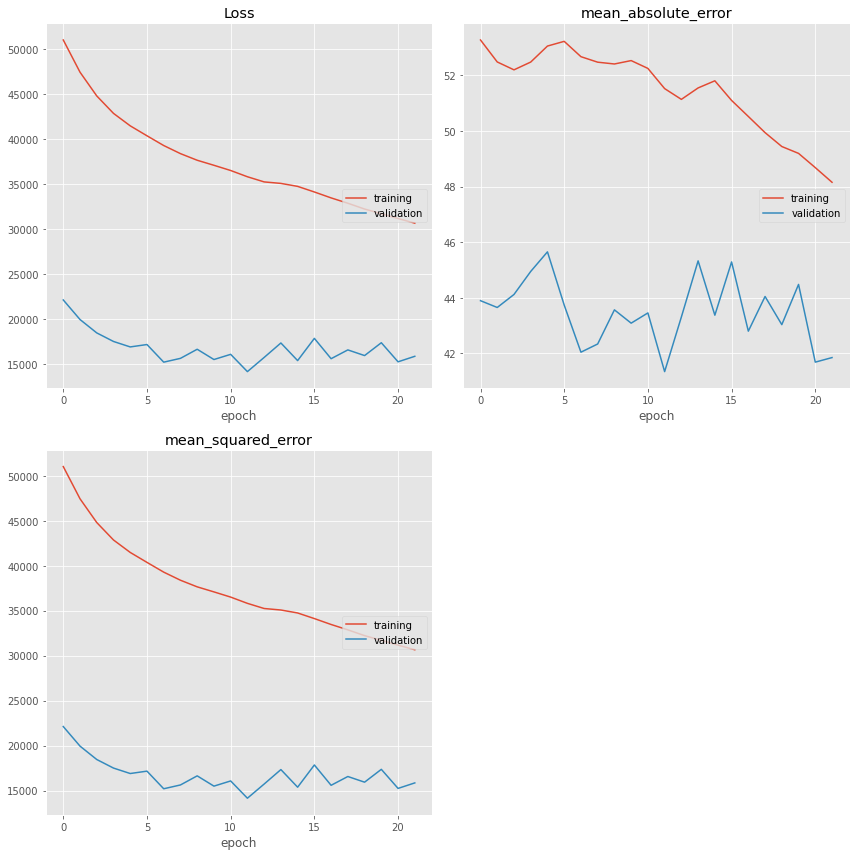

5/5 [==============================] - 0s 57ms/step
Accuracy:  63.5538%

 	 RMSE: 20.914111051540665, MAE: 15.575101534153045

 --- Overall Score --- 
	18.244606292846854
    
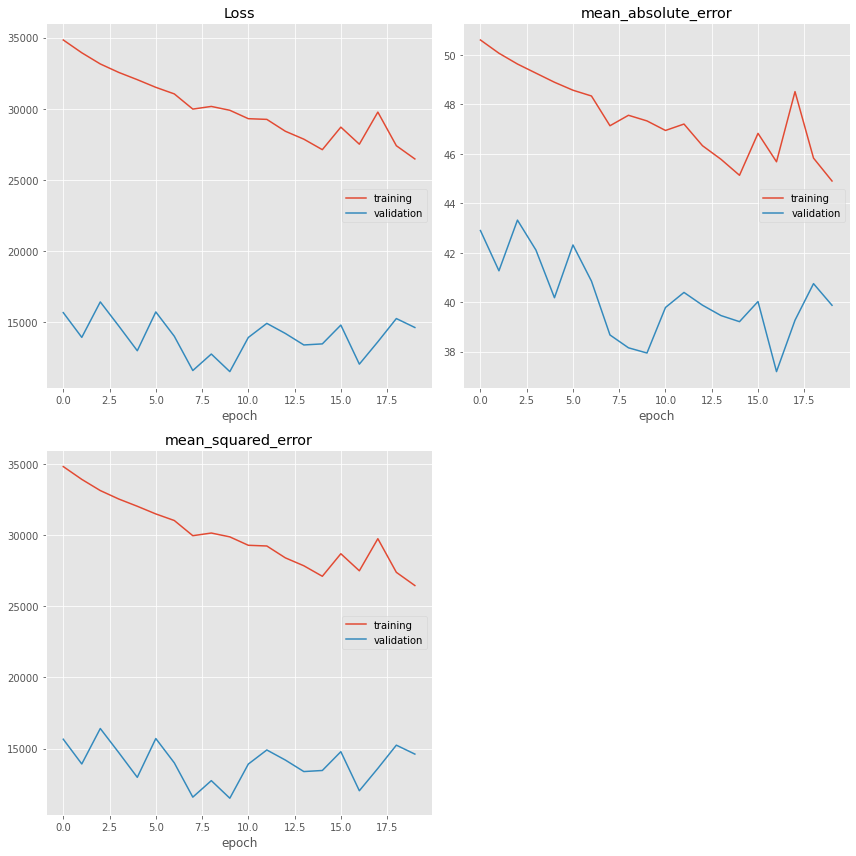


### countinued with larger validation set

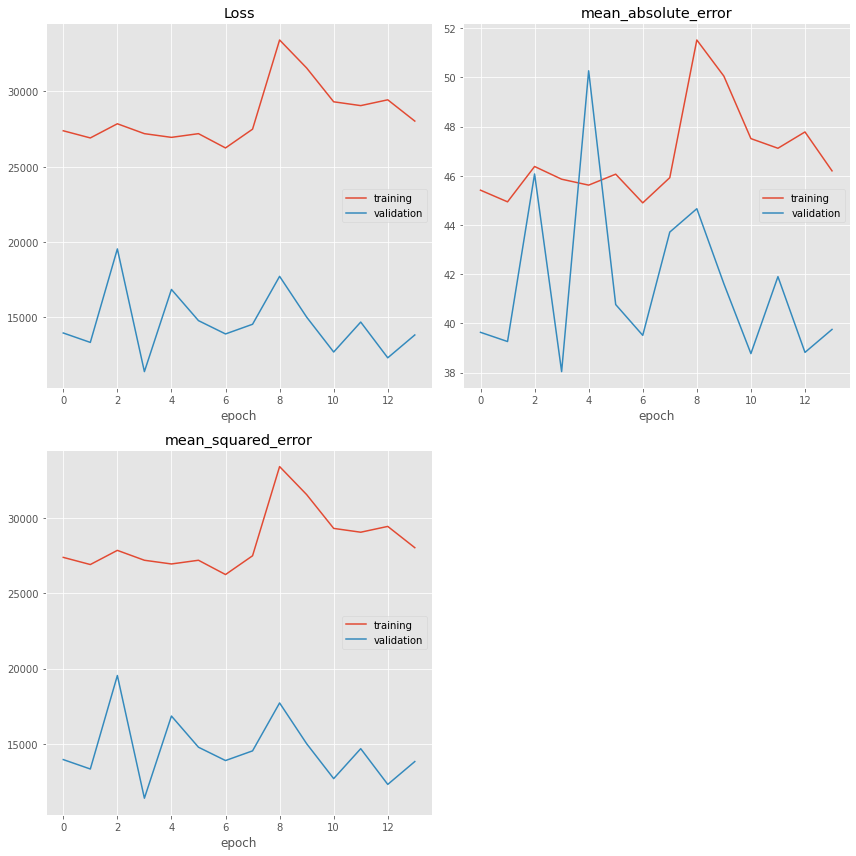

5/5 [==============================] - 0s 50ms/step
Accuracy:  65.3303%

 	 RMSE: 21.09188864577762, MAE: 16.1191686469215

 --- Overall Score --- 
	18.605528646349562

## Encoder-Decoder 288in 288 out 
## Epoch : 500

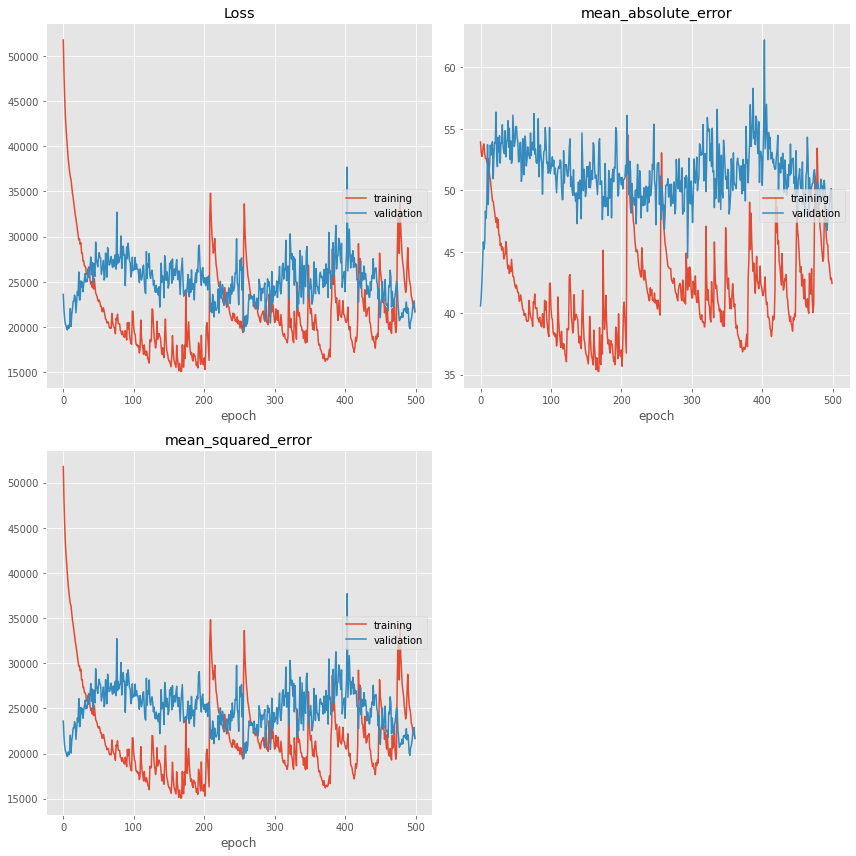

## Encoder-Decoder 288in 288 out 
## Epoch : 500

['TurbID','Day','RPM', 'Wspd_cos', 'Wspd',
       'P_max','TSR', 'Prtv','Patv']

Epoch 1/500
2022-07-13 10:20:08.018268: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
103/103 [==============================] - 28s 198ms/step - loss: 40785.8867 - mean_squared_error: 40785.8906 - mean_absolute_error: 57.8592 - val_loss: 30180.4375 - val_mean_squared_error: 30180.4395 - val_mean_absolute_error: 47.8843
Epoch 2/500
103/103 [==============================] - 19s 184ms/step - loss: 36601.3945 - mean_squared_error: 36601.3984 - mean_absolute_error: 55.7910 - val_loss: 27596.7285 - val_mean_squared_error: 27596.7246 - val_mean_absolute_error: 47.5502
Epoch 3/500
103/103 [==============================] - 19s 182ms/step - loss: 33539.6289 - mean_squared_error: 33539.6367 - mean_absolute_error: 54.7887 - val_loss: 25827.8125 - val_mean_squared_error: 25827.8145 - val_mean_absolute_error: 47.9316
Epoch 4/500
103/103 [==============================] - 19s 180ms/step - loss: 31304.0469 - mean_squared_error: 31304.0605 - mean_absolute_error: 54.4711 - val_loss: 24696.2090 - val_mean_squared_error: 24696.2090 - val_mean_absolute_error: 48.8287
Epoch 5/500
103/103 [==============================] - 19s 181ms/step - loss: 29720.2598 - mean_squared_error: 29720.2637 - mean_absolute_error: 54.5958 - val_loss: 24040.9688 - val_mean_squared_error: 24040.9707 - val_mean_absolute_error: 49.9017
Epoch 6/500
103/103 [==============================] - 19s 183ms/step - loss: 28642.6309 - mean_squared_error: 28642.6270 - mean_absolute_error: 55.0271 - val_loss: 23730.1855 - val_mean_squared_error: 23730.1816 - val_mean_absolute_error: 51.1465
Epoch 7/500
103/103 [==============================] - 19s 182ms/step - loss: 27940.0508 - mean_squared_error: 27940.0488 - mean_absolute_error: 55.5793 - val_loss: 23629.9902 - val_mean_squared_error: 23629.9863 - val_mean_absolute_error: 52.2147
Epoch 8/500
103/103 [==============================] - 19s 181ms/step - loss: 27466.3828 - mean_squared_error: 27466.3867 - mean_absolute_error: 56.0093 - val_loss: 23444.4590 - val_mean_squared_error: 23444.4590 - val_mean_absolute_error: 52.5351
Epoch 9/500
103/103 [==============================] - 19s 181ms/step - loss: 26606.7930 - mean_squared_error: 26606.7988 - mean_absolute_error: 54.8464 - val_loss: 22663.7520 - val_mean_squared_error: 22663.7480 - val_mean_absolute_error: 50.5320
Epoch 10/500
103/103 [==============================] - 19s 183ms/step - loss: 25568.0664 - mean_squared_error: 25568.0703 - mean_absolute_error: 53.5017 - val_loss: 22966.3887 - val_mean_squared_error: 22966.3867 - val_mean_absolute_error: 52.1087
Epoch 11/500
103/103 [==============================] - 19s 182ms/step - loss: 24845.1035 - mean_squared_error: 24845.1074 - mean_absolute_error: 53.0426 - val_loss: 22887.4746 - val_mean_squared_error: 22887.4746 - val_mean_absolute_error: 51.3167
Epoch 12/500
103/103 [==============================] - 19s 181ms/step - loss: 24245.6387 - mean_squared_error: 24245.6484 - mean_absolute_error: 52.5853 - val_loss: 22464.3008 - val_mean_squared_error: 22464.3027 - val_mean_absolute_error: 50.5894
Epoch 13/500
103/103 [==============================] - 19s 181ms/step - loss: 23679.3887 - mean_squared_error: 23679.3789 - mean_absolute_error: 52.0813 - val_loss: 23112.1191 - val_mean_squared_error: 23112.1191 - val_mean_absolute_error: 52.5691
Epoch 14/500
103/103 [==============================] - 19s 184ms/step - loss: 22906.7559 - mean_squared_error: 22906.7539 - mean_absolute_error: 51.0636 - val_loss: 23191.6992 - val_mean_squared_error: 23191.6973 - val_mean_absolute_error: 52.1985
Epoch 15/500
103/103 [==============================] - 19s 182ms/step - loss: 22255.3672 - mean_squared_error: 22255.3672 - mean_absolute_error: 50.2011 - val_loss: 23049.8477 - val_mean_squared_error: 23049.8457 - val_mean_absolute_error: 53.1724
Epoch 16/500
103/103 [==============================] - 19s 181ms/step - loss: 21468.3652 - mean_squared_error: 21468.3652 - mean_absolute_error: 49.3588 - val_loss: 23866.3711 - val_mean_squared_error: 23866.3691 - val_mean_absolute_error: 54.3710
Epoch 17/500
103/103 [==============================] - 19s 181ms/step - loss: 21237.8438 - mean_squared_error: 21237.8379 - mean_absolute_error: 49.4597 - val_loss: 22192.0566 - val_mean_squared_error: 22192.0547 - val_mean_absolute_error: 51.2359
Epoch 18/500
103/103 [==============================] - 19s 183ms/step - loss: 21197.8242 - mean_squared_error: 21197.8301 - mean_absolute_error: 49.6227 - val_loss: 23973.2734 - val_mean_squared_error: 23973.2715 - val_mean_absolute_error: 54.4474
Epoch 19/500
103/103 [==============================] - 19s 182ms/step - loss: 20422.7656 - mean_squared_error: 20422.7676 - mean_absolute_error: 48.7092 - val_loss: 23363.9551 - val_mean_squared_error: 23363.9551 - val_mean_absolute_error: 54.2358
Epoch 20/500
103/103 [==============================] - 19s 181ms/step - loss: 20353.3457 - mean_squared_error: 20353.3457 - mean_absolute_error: 48.8181 - val_loss: 23766.8691 - val_mean_squared_error: 23766.8711 - val_mean_absolute_error: 53.6292
Epoch 21/500
103/103 [==============================] - 19s 181ms/step - loss: 19863.2148 - mean_squared_error: 19863.2188 - mean_absolute_error: 48.2666 - val_loss: 24401.3730 - val_mean_squared_error: 24401.3770 - val_mean_absolute_error: 54.5480
Epoch 22/500
103/103 [==============================] - 19s 183ms/step - loss: 19086.1309 - mean_squared_error: 19086.1309 - mean_absolute_error: 47.1404 - val_loss: 24494.9219 - val_mean_squared_error: 24494.9258 - val_mean_absolute_error: 54.7480
Epoch 23/500
103/103 [==============================] - 19s 182ms/step - loss: 18683.2852 - mean_squared_error: 18683.2852 - mean_absolute_error: 46.7452 - val_loss: 24020.7969 - val_mean_squared_error: 24020.7949 - val_mean_absolute_error: 54.4461
Epoch 24/500
103/103 [==============================] - 19s 181ms/step - loss: 18262.4004 - mean_squared_error: 18262.4004 - mean_absolute_error: 46.2971 - val_loss: 24203.3418 - val_mean_squared_error: 24203.3398 - val_mean_absolute_error: 53.4185
Epoch 25/500
103/103 [==============================] - 19s 181ms/step - loss: 18394.2539 - mean_squared_error: 18394.2520 - mean_absolute_error: 46.4023 - val_loss: 24177.6016 - val_mean_squared_error: 24177.6035 - val_mean_absolute_error: 53.4207
Epoch 26/500
103/103 [==============================] - 19s 183ms/step - loss: 17558.4043 - mean_squared_error: 17558.4043 - mean_absolute_error: 45.3995 - val_loss: 24636.2910 - val_mean_squared_error: 24636.2910 - val_mean_absolute_error: 54.0102
Epoch 27/500
103/103 [==============================] - 19s 182ms/step - loss: 17065.4121 - mean_squared_error: 17065.4102 - mean_absolute_error: 44.7824 - val_loss: 25680.0625 - val_mean_squared_error: 25680.0605 - val_mean_absolute_error: 55.6659
Epoch 28/500
103/103 [==============================] - 19s 181ms/step - loss: 16844.1934 - mean_squared_error: 16844.1914 - mean_absolute_error: 44.4739 - val_loss: 25576.3340 - val_mean_squared_error: 25576.3340 - val_mean_absolute_error: 55.2510
Epoch 29/500
103/103 [==============================] - 19s 182ms/step - loss: 16585.2617 - mean_squared_error: 16585.2617 - mean_absolute_error: 44.2576 - val_loss: 25774.3066 - val_mean_squared_error: 25774.3066 - val_mean_absolute_error: 55.5296
Epoch 30/500
103/103 [==============================] - 19s 184ms/step - loss: 16166.0605 - mean_squared_error: 16166.0625 - mean_absolute_error: 43.5884 - val_loss: 25633.0156 - val_mean_squared_error: 25633.0176 - val_mean_absolute_error: 54.9915
Epoch 31/500
103/103 [==============================] - 19s 182ms/step - loss: 15641.1748 - mean_squared_error: 15641.1807 - mean_absolute_error: 42.8799 - val_loss: 25757.8594 - val_mean_squared_error: 25757.8555 - val_mean_absolute_error: 55.2390
Epoch 32/500
103/103 [==============================] - 19s 180ms/step - loss: 15445.4795 - mean_squared_error: 15445.4814 - mean_absolute_error: 42.6489 - val_loss: 27217.1230 - val_mean_squared_error: 27217.1289 - val_mean_absolute_error: 57.4315
Epoch 33/500
103/103 [==============================] - 18s 178ms/step - loss: 15499.4619 - mean_squared_error: 15499.4590 - mean_absolute_error: 42.8392 - val_loss: 28056.1191 - val_mean_squared_error: 28056.1211 - val_mean_absolute_error: 57.5647
Epoch 34/500
103/103 [==============================] - 19s 181ms/step - loss: 15231.4980 - mean_squared_error: 15231.4961 - mean_absolute_error: 42.3382 - val_loss: 27335.3516 - val_mean_squared_error: 27335.3516 - val_mean_absolute_error: 56.5672
Epoch 35/500
103/103 [==============================] - 18s 179ms/step - loss: 14727.6738 - mean_squared_error: 14727.6709 - mean_absolute_error: 41.6303 - val_loss: 27098.6719 - val_mean_squared_error: 27098.6719 - val_mean_absolute_error: 56.5607
Epoch 36/500
103/103 [==============================] - 18s 177ms/step - loss: 18519.0391 - mean_squared_error: 18519.0332 - mean_absolute_error: 46.9939 - val_loss: 26098.5742 - val_mean_squared_error: 26098.5703 - val_mean_absolute_error: 55.3619
Epoch 37/500
103/103 [==============================] - 18s 178ms/step - loss: 16676.8145 - mean_squared_error: 16676.8145 - mean_absolute_error: 44.5421 - val_loss: 26826.1191 - val_mean_squared_error: 26826.1172 - val_mean_absolute_error: 55.4681
Epoch 38/500
103/103 [==============================] - 19s 180ms/step - loss: 15623.2031 - mean_squared_error: 15623.2041 - mean_absolute_error: 43.0051 - val_loss: 26497.4512 - val_mean_squared_error: 26497.4512 - val_mean_absolute_error: 54.9565
Epoch 39/500
103/103 [==============================] - 18s 179ms/step - loss: 14881.0039 - mean_squared_error: 14881.0039 - mean_absolute_error: 41.8175 - val_loss: 28827.9668 - val_mean_squared_error: 28827.9648 - val_mean_absolute_error: 57.7564
Epoch 40/500
103/103 [==============================] - 18s 177ms/step - loss: 14418.1436 - mean_squared_error: 14418.1396 - mean_absolute_error: 41.2410 - val_loss: 27767.0059 - val_mean_squared_error: 27767.0039 - val_mean_absolute_error: 56.0305
Epoch 41/500
103/103 [==============================] - 18s 178ms/step - loss: 14003.7881 - mean_squared_error: 14003.7900 - mean_absolute_error: 40.4707 - val_loss: 28618.3398 - val_mean_squared_error: 28618.3379 - val_mean_absolute_error: 56.2793
Epoch 42/500
103/103 [==============================] - 19s 181ms/step - loss: 13832.8018 - mean_squared_error: 13832.8066 - mean_absolute_error: 40.1804 - val_loss: 27893.9277 - val_mean_squared_error: 27893.9277 - val_mean_absolute_error: 56.6738
Epoch 43/500
103/103 [==============================] - 18s 179ms/step - loss: 13855.7402 - mean_squared_error: 13855.7402 - mean_absolute_error: 40.2019 - val_loss: 29957.8535 - val_mean_squared_error: 29957.8516 - val_mean_absolute_error: 58.1915
Epoch 44/500
103/103 [==============================] - 18s 177ms/step - loss: 14009.7910 - mean_squared_error: 14009.7939 - mean_absolute_error: 40.4982 - val_loss: 28075.6797 - val_mean_squared_error: 28075.6797 - val_mean_absolute_error: 57.2143
Epoch 45/500
103/103 [==============================] - 18s 178ms/step - loss: 14247.4424 - mean_squared_error: 14247.4424 - mean_absolute_error: 40.8349 - val_loss: 27856.8418 - val_mean_squared_error: 27856.8477 - val_mean_absolute_error: 56.0121
Epoch 46/500
103/103 [==============================] - 18s 179ms/step - loss: 13792.4590 - mean_squared_error: 13792.4590 - mean_absolute_error: 40.0755 - val_loss: 29176.1348 - val_mean_squared_error: 29176.1309 - val_mean_absolute_error: 57.4669
Epoch 47/500
103/103 [==============================] - 18s 179ms/step - loss: 13020.7734 - mean_squared_error: 13020.7734 - mean_absolute_error: 38.8887 - val_loss: 29929.4258 - val_mean_squared_error: 29929.4238 - val_mean_absolute_error: 57.5372
Epoch 48/500
103/103 [==============================] - 18s 178ms/step - loss: 13587.0898 - mean_squared_error: 13587.0850 - mean_absolute_error: 39.6985 - val_loss: 27301.8320 - val_mean_squared_error: 27301.8340 - val_mean_absolute_error: 55.0606
Epoch 49/500
103/103 [==============================] - 18s 178ms/step - loss: 12833.1465 - mean_squared_error: 12833.1504 - mean_absolute_error: 38.6028 - val_loss: 30295.1895 - val_mean_squared_error: 30295.1895 - val_mean_absolute_error: 59.0350
Epoch 50/500
103/103 [==============================] - 19s 181ms/step - loss: 12616.6611 - mean_squared_error: 12616.6621 - mean_absolute_error: 38.2362 - val_loss: 28437.2012 - val_mean_squared_error: 28437.2012 - val_mean_absolute_error: 56.2246
Epoch 51/500
103/103 [==============================] - 18s 179ms/step - loss: 11950.8623 - mean_squared_error: 11950.8643 - mean_absolute_error: 37.1036 - val_loss: 29253.8242 - val_mean_squared_error: 29253.8320 - val_mean_absolute_error: 57.7337
Epoch 52/500
103/103 [==============================] - 18s 178ms/step - loss: 11693.4814 - mean_squared_error: 11693.4854 - mean_absolute_error: 36.6417 - val_loss: 31399.2422 - val_mean_squared_error: 31399.2422 - val_mean_absolute_error: 59.5499
Epoch 53/500
103/103 [==============================] - 18s 179ms/step - loss: 11884.1270 - mean_squared_error: 11884.1270 - mean_absolute_error: 36.9381 - val_loss: 30646.9902 - val_mean_squared_error: 30646.9902 - val_mean_absolute_error: 58.7548
Epoch 54/500
103/103 [==============================] - 19s 182ms/step - loss: 11593.4150 - mean_squared_error: 11593.4170 - mean_absolute_error: 36.5216 - val_loss: 31964.8984 - val_mean_squared_error: 31964.8945 - val_mean_absolute_error: 59.9436
Epoch 55/500
103/103 [==============================] - 19s 180ms/step - loss: 11256.5166 - mean_squared_error: 11256.5146 - mean_absolute_error: 35.8724 - val_loss: 31086.3164 - val_mean_squared_error: 31086.3164 - val_mean_absolute_error: 58.7492
Epoch 56/500
103/103 [==============================] - 18s 178ms/step - loss: 10952.2051 - mean_squared_error: 10952.2021 - mean_absolute_error: 35.2650 - val_loss: 30771.9141 - val_mean_squared_error: 30771.9141 - val_mean_absolute_error: 57.8611
Epoch 57/500
103/103 [==============================] - 18s 179ms/step - loss: 10824.4434 - mean_squared_error: 10824.4443 - mean_absolute_error: 35.0848 - val_loss: 29260.3848 - val_mean_squared_error: 29260.3867 - val_mean_absolute_error: 57.3179
Epoch 58/500
103/103 [==============================] - 19s 181ms/step - loss: 10925.4053 - mean_squared_error: 10925.4092 - mean_absolute_error: 35.2128 - val_loss: 31627.4082 - val_mean_squared_error: 31627.4141 - val_mean_absolute_error: 58.8620
Epoch 59/500
103/103 [==============================] - 19s 180ms/step - loss: 10647.3740 - mean_squared_error: 10647.3750 - mean_absolute_error: 34.7394 - val_loss: 31818.2051 - val_mean_squared_error: 31818.2012 - val_mean_absolute_error: 59.2372
Epoch 60/500
103/103 [==============================] - 18s 178ms/step - loss: 11070.7393 - mean_squared_error: 11070.7412 - mean_absolute_error: 35.6258 - val_loss: 32474.1953 - val_mean_squared_error: 32474.1992 - val_mean_absolute_error: 60.5493
Epoch 61/500
103/103 [==============================] - 18s 178ms/step - loss: 12344.6445 - mean_squared_error: 12344.6504 - mean_absolute_error: 37.6636 - val_loss: 26902.5918 - val_mean_squared_error: 26902.5918 - val_mean_absolute_error: 55.1497
Epoch 62/500
103/103 [==============================] - 19s 180ms/step - loss: 11966.4316 - mean_squared_error: 11966.4316 - mean_absolute_error: 37.0507 - val_loss: 28296.4609 - val_mean_squared_error: 28296.4590 - val_mean_absolute_error: 54.8723
Epoch 63/500
103/103 [==============================] - 19s 180ms/step - loss: 10731.5225 - mean_squared_error: 10731.5225 - mean_absolute_error: 35.0687 - val_loss: 31535.0840 - val_mean_squared_error: 31535.0840 - val_mean_absolute_error: 58.9115
Epoch 64/500
103/103 [==============================] - 18s 178ms/step - loss: 10299.8555 - mean_squared_error: 10299.8564 - mean_absolute_error: 34.2679 - val_loss: 29522.8203 - val_mean_squared_error: 29522.8184 - val_mean_absolute_error: 56.3751
Epoch 65/500
103/103 [==============================] - 18s 178ms/step - loss: 9991.9775 - mean_squared_error: 9991.9775 - mean_absolute_error: 33.6598 - val_loss: 30855.9258 - val_mean_squared_error: 30855.9238 - val_mean_absolute_error: 57.8304
Epoch 66/500
103/103 [==============================] - 19s 180ms/step - loss: 10387.7949 - mean_squared_error: 10387.7969 - mean_absolute_error: 34.4199 - val_loss: 33244.4414 - val_mean_squared_error: 33244.4492 - val_mean_absolute_error: 60.9735
Epoch 67/500
103/103 [==============================] - 18s 179ms/step - loss: 10092.8281 - mean_squared_error: 10092.8252 - mean_absolute_error: 33.7563 - val_loss: 31673.4395 - val_mean_squared_error: 31673.4375 - val_mean_absolute_error: 58.8373
Epoch 68/500
103/103 [==============================] - 18s 177ms/step - loss: 9853.9395 - mean_squared_error: 9853.9375 - mean_absolute_error: 33.3522 - val_loss: 30824.0195 - val_mean_squared_error: 30824.0156 - val_mean_absolute_error: 58.1767
Epoch 69/500
103/103 [==============================] - 18s 178ms/step - loss: 14329.5439 - mean_squared_error: 14329.5430 - mean_absolute_error: 40.0982 - val_loss: 26865.2578 - val_mean_squared_error: 26865.2578 - val_mean_absolute_error: 55.0010
Epoch 70/500
103/103 [==============================] - 19s 180ms/step - loss: 13989.1768 - mean_squared_error: 13989.1768 - mean_absolute_error: 40.0799 - val_loss: 28760.3672 - val_mean_squared_error: 28760.3691 - val_mean_absolute_error: 56.6700
Epoch 71/500
103/103 [==============================] - 19s 180ms/step - loss: 12430.7314 - mean_squared_error: 12430.7305 - mean_absolute_error: 37.7312 - val_loss: 30970.1465 - val_mean_squared_error: 30970.1484 - val_mean_absolute_error: 58.4690
Epoch 72/500
103/103 [==============================] - 18s 179ms/step - loss: 11375.6895 - mean_squared_error: 11375.6904 - mean_absolute_error: 36.0909 - val_loss: 30882.2207 - val_mean_squared_error: 30882.2188 - val_mean_absolute_error: 58.6710
Epoch 73/500
103/103 [==============================] - 18s 179ms/step - loss: 10526.5693 - mean_squared_error: 10526.5693 - mean_absolute_error: 34.6310 - val_loss: 31332.5410 - val_mean_squared_error: 31332.5488 - val_mean_absolute_error: 59.0317
Epoch 74/500
103/103 [==============================] - 19s 181ms/step - loss: 10276.8965 - mean_squared_error: 10276.8965 - mean_absolute_error: 34.1655 - val_loss: 32985.5312 - val_mean_squared_error: 32985.5312 - val_mean_absolute_error: 61.3948
Epoch 75/500
103/103 [==============================] - 18s 178ms/step - loss: 9971.7881 - mean_squared_error: 9971.7881 - mean_absolute_error: 33.7011 - val_loss: 30808.3223 - val_mean_squared_error: 30808.3203 - val_mean_absolute_error: 58.2023
Epoch 76/500
103/103 [==============================] - 18s 177ms/step - loss: 9520.9287 - mean_squared_error: 9520.9297 - mean_absolute_error: 32.8192 - val_loss: 31671.6875 - val_mean_squared_error: 31671.6836 - val_mean_absolute_error: 59.0437
Epoch 77/500
103/103 [==============================] - 18s 179ms/step - loss: 9126.6758 - mean_squared_error: 9126.6748 - mean_absolute_error: 32.1050 - val_loss: 32704.6484 - val_mean_squared_error: 32704.6484 - val_mean_absolute_error: 60.5691
Epoch 78/500
103/103 [==============================] - 19s 184ms/step - loss: 9467.3340 - mean_squared_error: 9467.3291 - mean_absolute_error: 32.7572 - val_loss: 32973.5586 - val_mean_squared_error: 32973.5586 - val_mean_absolute_error: 60.1198
Epoch 79/500
103/103 [==============================] - 19s 182ms/step - loss: 12016.8916 - mean_squared_error: 12016.8955 - mean_absolute_error: 37.0672 - val_loss: 32875.3359 - val_mean_squared_error: 32875.3398 - val_mean_absolute_error: 60.5113
Epoch 80/500
103/103 [==============================] - 19s 181ms/step - loss: 10276.0215 - mean_squared_error: 10276.0225 - mean_absolute_error: 34.4280 - val_loss: 31800.2637 - val_mean_squared_error: 31800.2598 - val_mean_absolute_error: 58.8072
Epoch 81/500
103/103 [==============================] - 19s 181ms/step - loss: 9482.5938 - mean_squared_error: 9482.5928 - mean_absolute_error: 32.9252 - val_loss: 32565.7500 - val_mean_squared_error: 32565.7480 - val_mean_absolute_error: 59.4894
Epoch 82/500
103/103 [==============================] - 19s 183ms/step - loss: 9631.9834 - mean_squared_error: 9631.9834 - mean_absolute_error: 33.1857 - val_loss: 34073.2266 - val_mean_squared_error: 34073.2266 - val_mean_absolute_error: 61.3677
Epoch 83/500
103/103 [==============================] - 19s 182ms/step - loss: 9278.1641 - mean_squared_error: 9278.1650 - mean_absolute_error: 32.4834 - val_loss: 34844.4609 - val_mean_squared_error: 34844.4531 - val_mean_absolute_error: 61.8077
Epoch 84/500
103/103 [==============================] - 18s 178ms/step - loss: 9561.1299 - mean_squared_error: 9561.1279 - mean_absolute_error: 32.9129 - val_loss: 33656.2188 - val_mean_squared_error: 33656.2148 - val_mean_absolute_error: 60.8102
Epoch 85/500
103/103 [==============================] - 18s 179ms/step - loss: 9158.2041 - mean_squared_error: 9158.2021 - mean_absolute_error: 32.2313 - val_loss: 33490.4219 - val_mean_squared_error: 33490.4258 - val_mean_absolute_error: 60.7112
Epoch 86/500
103/103 [==============================] - 19s 182ms/step - loss: 9267.1836 - mean_squared_error: 9267.1865 - mean_absolute_error: 32.4270 - val_loss: 33887.2383 - val_mean_squared_error: 33887.2422 - val_mean_absolute_error: 61.0519
Epoch 87/500
103/103 [==============================] - 19s 182ms/step - loss: 8601.2383 - mean_squared_error: 8601.2334 - mean_absolute_error: 31.1732 - val_loss: 32665.2422 - val_mean_squared_error: 32665.2422 - val_mean_absolute_error: 59.4862
Epoch 88/500
103/103 [==============================] - 19s 180ms/step - loss: 8455.2959 - mean_squared_error: 8455.2979 - mean_absolute_error: 30.8839 - val_loss: 32725.2891 - val_mean_squared_error: 32725.2871 - val_mean_absolute_error: 58.7497
Epoch 89/500
103/103 [==============================] - 19s 181ms/step - loss: 8360.5986 - mean_squared_error: 8360.5957 - mean_absolute_error: 30.6655 - val_loss: 33380.9102 - val_mean_squared_error: 33380.9062 - val_mean_absolute_error: 59.5981
Epoch 90/500
103/103 [==============================] - 19s 185ms/step - loss: 8421.9844 - mean_squared_error: 8421.9824 - mean_absolute_error: 30.7382 - val_loss: 32863.5195 - val_mean_squared_error: 32863.5195 - val_mean_absolute_error: 58.7846
Epoch 91/500
103/103 [==============================] - 19s 182ms/step - loss: 8159.9214 - mean_squared_error: 8159.9199 - mean_absolute_error: 30.1626 - val_loss: 33323.1289 - val_mean_squared_error: 33323.1367 - val_mean_absolute_error: 59.8370
Epoch 92/500
103/103 [==============================] - 19s 180ms/step - loss: 7949.4102 - mean_squared_error: 7949.4116 - mean_absolute_error: 29.7555 - val_loss: 35390.3477 - val_mean_squared_error: 35390.3438 - val_mean_absolute_error: 61.5064
Epoch 93/500
103/103 [==============================] - 19s 180ms/step - loss: 7815.4766 - mean_squared_error: 7815.4780 - mean_absolute_error: 29.4786 - val_loss: 34769.6367 - val_mean_squared_error: 34769.6367 - val_mean_absolute_error: 61.0847
Epoch 94/500
103/103 [==============================] - 19s 183ms/step - loss: 7869.3481 - mean_squared_error: 7869.3486 - mean_absolute_error: 29.5795 - val_loss: 35467.2891 - val_mean_squared_error: 35467.2891 - val_mean_absolute_error: 62.4288
Epoch 95/500
103/103 [==============================] - 19s 180ms/step - loss: 10310.2109 - mean_squared_error: 10310.2119 - mean_absolute_error: 34.0696 - val_loss: 34005.8984 - val_mean_squared_error: 34005.9102 - val_mean_absolute_error: 62.2136
Epoch 96/500
103/103 [==============================] - 18s 179ms/step - loss: 9912.1191 - mean_squared_error: 9912.1191 - mean_absolute_error: 33.7231 - val_loss: 32201.9727 - val_mean_squared_error: 32201.9688 - val_mean_absolute_error: 59.7826
Epoch 97/500
103/103 [==============================] - 18s 180ms/step - loss: 8700.1289 - mean_squared_error: 8700.1299 - mean_absolute_error: 31.4889 - val_loss: 31725.8574 - val_mean_squared_error: 31725.8594 - val_mean_absolute_error: 58.7494
Epoch 98/500
103/103 [==============================] - 19s 182ms/step - loss: 8121.5991 - mean_squared_error: 8121.5977 - mean_absolute_error: 30.2903 - val_loss: 33755.3164 - val_mean_squared_error: 33755.3164 - val_mean_absolute_error: 60.8630
Epoch 99/500
103/103 [==============================] - 19s 182ms/step - loss: 7848.5366 - mean_squared_error: 7848.5381 - mean_absolute_error: 29.7324 - val_loss: 32118.0566 - val_mean_squared_error: 32118.0547 - val_mean_absolute_error: 58.9404
Epoch 100/500
103/103 [==============================] - 18s 178ms/step - loss: 7712.1890 - mean_squared_error: 7712.1885 - mean_absolute_error: 29.3810 - val_loss: 33029.7695 - val_mean_squared_error: 33029.7734 - val_mean_absolute_error: 60.0394
Epoch 101/500
103/103 [==============================] - 19s 180ms/step - loss: 7681.3926 - mean_squared_error: 7681.3931 - mean_absolute_error: 29.2559 - val_loss: 33182.6523 - val_mean_squared_error: 33182.6562 - val_mean_absolute_error: 60.0671
Epoch 102/500
103/103 [==============================] - 19s 181ms/step - loss: 7434.0420 - mean_squared_error: 7434.0430 - mean_absolute_error: 28.7533 - val_loss: 33764.4219 - val_mean_squared_error: 33764.4219 - val_mean_absolute_error: 60.0756
Epoch 103/500
103/103 [==============================] - 19s 180ms/step - loss: 7212.7793 - mean_squared_error: 7212.7817 - mean_absolute_error: 28.2819 - val_loss: 33037.7109 - val_mean_squared_error: 33037.7188 - val_mean_absolute_error: 59.5619
Epoch 104/500
103/103 [==============================] - 18s 177ms/step - loss: 7155.2666 - mean_squared_error: 7155.2686 - mean_absolute_error: 28.1820 - val_loss: 33710.4375 - val_mean_squared_error: 33710.4375 - val_mean_absolute_error: 60.4884
Epoch 105/500
103/103 [==============================] - 18s 178ms/step - loss: 7011.0215 - mean_squared_error: 7011.0229 - mean_absolute_error: 27.8142 - val_loss: 33319.0938 - val_mean_squared_error: 33319.0938 - val_mean_absolute_error: 59.7802
Epoch 106/500
103/103 [==============================] - 19s 180ms/step - loss: 7015.1890 - mean_squared_error: 7015.1924 - mean_absolute_error: 27.7859 - val_loss: 33099.3477 - val_mean_squared_error: 33099.3438 - val_mean_absolute_error: 59.9021
Epoch 107/500
103/103 [==============================] - 18s 179ms/step - loss: 6952.4321 - mean_squared_error: 6952.4282 - mean_absolute_error: 27.6060 - val_loss: 33836.4492 - val_mean_squared_error: 33836.4531 - val_mean_absolute_error: 60.6051
Epoch 108/500
103/103 [==============================] - 18s 177ms/step - loss: 6794.4507 - mean_squared_error: 6794.4502 - mean_absolute_error: 27.2940 - val_loss: 34308.3359 - val_mean_squared_error: 34308.3281 - val_mean_absolute_error: 60.8557
Epoch 109/500
103/103 [==============================] - 18s 179ms/step - loss: 6551.6431 - mean_squared_error: 6551.6416 - mean_absolute_error: 26.7661 - val_loss: 34939.2773 - val_mean_squared_error: 34939.2734 - val_mean_absolute_error: 61.7948
Epoch 110/500
103/103 [==============================] - 19s 181ms/step - loss: 6609.6260 - mean_squared_error: 6609.6274 - mean_absolute_error: 26.8662 - val_loss: 32915.7734 - val_mean_squared_error: 32915.7695 - val_mean_absolute_error: 60.0208
Epoch 111/500
103/103 [==============================] - 19s 180ms/step - loss: 6586.0742 - mean_squared_error: 6586.0728 - mean_absolute_error: 26.7954 - val_loss: 33963.0781 - val_mean_squared_error: 33963.0742 - val_mean_absolute_error: 60.9624
Epoch 112/500
103/103 [==============================] - 18s 177ms/step - loss: 6486.7017 - mean_squared_error: 6486.7012 - mean_absolute_error: 26.5425 - val_loss: 34319.5625 - val_mean_squared_error: 34319.5625 - val_mean_absolute_error: 60.8486
Epoch 113/500
103/103 [==============================] - 18s 179ms/step - loss: 6606.6084 - mean_squared_error: 6606.6104 - mean_absolute_error: 26.8134 - val_loss: 35509.6484 - val_mean_squared_error: 35509.6367 - val_mean_absolute_error: 62.2833
Epoch 114/500
103/103 [==============================] - 19s 181ms/step - loss: 6431.4561 - mean_squared_error: 6431.4575 - mean_absolute_error: 26.4219 - val_loss: 34620.2812 - val_mean_squared_error: 34620.2852 - val_mean_absolute_error: 61.0745
Epoch 115/500
103/103 [==============================] - 18s 179ms/step - loss: 6285.3428 - mean_squared_error: 6285.3394 - mean_absolute_error: 26.0713 - val_loss: 34382.2383 - val_mean_squared_error: 34382.2383 - val_mean_absolute_error: 60.6784
Epoch 116/500
103/103 [==============================] - 18s 178ms/step - loss: 6873.5103 - mean_squared_error: 6873.5112 - mean_absolute_error: 27.3078 - val_loss: 35388.9609 - val_mean_squared_error: 35388.9609 - val_mean_absolute_error: 61.8443
Epoch 117/500
103/103 [==============================] - 18s 179ms/step - loss: 9154.1221 - mean_squared_error: 9154.1260 - mean_absolute_error: 31.9782 - val_loss: 34611.0625 - val_mean_squared_error: 34611.0586 - val_mean_absolute_error: 61.6027
Epoch 118/500
103/103 [==============================] - 19s 181ms/step - loss: 7509.5884 - mean_squared_error: 7509.5884 - mean_absolute_error: 28.7818 - val_loss: 32968.9492 - val_mean_squared_error: 32968.9492 - val_mean_absolute_error: 59.4909
Epoch 119/500
103/103 [==============================] - 19s 180ms/step - loss: 6969.7373 - mean_squared_error: 6969.7373 - mean_absolute_error: 27.6451 - val_loss: 35449.1016 - val_mean_squared_error: 35449.0938 - val_mean_absolute_error: 61.8426
Epoch 120/500
103/103 [==============================] - 18s 178ms/step - loss: 6669.8950 - mean_squared_error: 6669.8945 - mean_absolute_error: 26.9891 - val_loss: 35422.0977 - val_mean_squared_error: 35422.0977 - val_mean_absolute_error: 61.2071
Epoch 121/500
103/103 [==============================] - 19s 180ms/step - loss: 8520.7627 - mean_squared_error: 8520.7637 - mean_absolute_error: 30.5944 - val_loss: 31929.3496 - val_mean_squared_error: 31929.3516 - val_mean_absolute_error: 60.1800
Epoch 122/500
103/103 [==============================] - 19s 181ms/step - loss: 9070.7432 - mean_squared_error: 9070.7441 - mean_absolute_error: 31.9135 - val_loss: 32365.6895 - val_mean_squared_error: 32365.6934 - val_mean_absolute_error: 59.4812
Epoch 123/500
103/103 [==============================] - 19s 180ms/step - loss: 7823.6587 - mean_squared_error: 7823.6587 - mean_absolute_error: 29.4826 - val_loss: 34207.7109 - val_mean_squared_error: 34207.7109 - val_mean_absolute_error: 61.1738
Epoch 124/500
103/103 [==============================] - 18s 179ms/step - loss: 7243.0776 - mean_squared_error: 7243.0767 - mean_absolute_error: 28.2582 - val_loss: 33982.5508 - val_mean_squared_error: 33982.5508 - val_mean_absolute_error: 60.7524
Epoch 125/500
103/103 [==============================] - 19s 181ms/step - loss: 6927.6548 - mean_squared_error: 6927.6558 - mean_absolute_error: 27.5535 - val_loss: 33658.4766 - val_mean_squared_error: 33658.4844 - val_mean_absolute_error: 60.1823
Epoch 126/500
103/103 [==============================] - 19s 182ms/step - loss: 6684.7827 - mean_squared_error: 6684.7847 - mean_absolute_error: 27.0610 - val_loss: 34715.2852 - val_mean_squared_error: 34715.2930 - val_mean_absolute_error: 61.4673
Epoch 127/500
103/103 [==============================] - 19s 182ms/step - loss: 6637.4775 - mean_squared_error: 6637.4800 - mean_absolute_error: 26.9173 - val_loss: 33559.5547 - val_mean_squared_error: 33559.5547 - val_mean_absolute_error: 60.4635
Epoch 128/500
103/103 [==============================] - 19s 181ms/step - loss: 6378.7642 - mean_squared_error: 6378.7661 - mean_absolute_error: 26.3206 - val_loss: 34019.9297 - val_mean_squared_error: 34019.9297 - val_mean_absolute_error: 60.5458
Epoch 129/500
103/103 [==============================] - 19s 182ms/step - loss: 6224.3003 - mean_squared_error: 6224.3013 - mean_absolute_error: 25.9796 - val_loss: 33548.6367 - val_mean_squared_error: 33548.6406 - val_mean_absolute_error: 60.3344
Epoch 130/500
103/103 [==============================] - 19s 183ms/step - loss: 6212.7373 - mean_squared_error: 6212.7373 - mean_absolute_error: 25.9242 - val_loss: 33857.6875 - val_mean_squared_error: 33857.6875 - val_mean_absolute_error: 60.3471
Epoch 131/500
103/103 [==============================] - 19s 181ms/step - loss: 6084.3232 - mean_squared_error: 6084.3218 - mean_absolute_error: 25.6242 - val_loss: 34278.6562 - val_mean_squared_error: 34278.6602 - val_mean_absolute_error: 61.2174
Epoch 132/500
103/103 [==============================] - 19s 180ms/step - loss: 5991.9365 - mean_squared_error: 5991.9351 - mean_absolute_error: 25.3972 - val_loss: 34209.0312 - val_mean_squared_error: 34209.0273 - val_mean_absolute_error: 61.0428
Epoch 133/500
103/103 [==============================] - 19s 181ms/step - loss: 5978.6411 - mean_squared_error: 5978.6406 - mean_absolute_error: 25.3532 - val_loss: 34484.9688 - val_mean_squared_error: 34484.9688 - val_mean_absolute_error: 61.0085
Epoch 134/500
103/103 [==============================] - 19s 183ms/step - loss: 5952.7397 - mean_squared_error: 5952.7397 - mean_absolute_error: 25.2895 - val_loss: 34801.6992 - val_mean_squared_error: 34801.6992 - val_mean_absolute_error: 61.3442
Epoch 135/500
103/103 [==============================] - 19s 182ms/step - loss: 5824.3647 - mean_squared_error: 5824.3643 - mean_absolute_error: 24.9992 - val_loss: 34522.9570 - val_mean_squared_error: 34522.9492 - val_mean_absolute_error: 60.9972
Epoch 136/500
103/103 [==============================] - 19s 181ms/step - loss: 5813.9331 - mean_squared_error: 5813.9331 - mean_absolute_error: 24.9283 - val_loss: 35721.3281 - val_mean_squared_error: 35721.3242 - val_mean_absolute_error: 62.2599
Epoch 137/500
103/103 [==============================] - 19s 181ms/step - loss: 5708.6592 - mean_squared_error: 5708.6577 - mean_absolute_error: 24.6960 - val_loss: 34135.4180 - val_mean_squared_error: 34135.4141 - val_mean_absolute_error: 60.3463
Epoch 138/500
103/103 [==============================] - 19s 183ms/step - loss: 6027.0820 - mean_squared_error: 6027.0830 - mean_absolute_error: 25.4123 - val_loss: 35967.5703 - val_mean_squared_error: 35967.5664 - val_mean_absolute_error: 62.2785
Epoch 139/500
103/103 [==============================] - 19s 181ms/step - loss: 7070.5879 - mean_squared_error: 7070.5898 - mean_absolute_error: 27.1825 - val_loss: 30818.2012 - val_mean_squared_error: 30818.2012 - val_mean_absolute_error: 59.1478
Epoch 140/500
103/103 [==============================] - 18s 179ms/step - loss: 10507.7881 - mean_squared_error: 10507.7920 - mean_absolute_error: 34.4551 - val_loss: 34072.5117 - val_mean_squared_error: 34072.5078 - val_mean_absolute_error: 61.5758
Epoch 141/500
103/103 [==============================] - 18s 179ms/step - loss: 8079.9634 - mean_squared_error: 8079.9639 - mean_absolute_error: 29.9724 - val_loss: 32614.8184 - val_mean_squared_error: 32614.8223 - val_mean_absolute_error: 59.5614
Epoch 142/500
103/103 [==============================] - 19s 180ms/step - loss: 7315.5850 - mean_squared_error: 7315.5845 - mean_absolute_error: 28.3801 - val_loss: 33211.4609 - val_mean_squared_error: 33211.4609 - val_mean_absolute_error: 59.7612
Epoch 143/500
103/103 [==============================] - 19s 180ms/step - loss: 7651.8662 - mean_squared_error: 7651.8687 - mean_absolute_error: 28.9883 - val_loss: 33101.8945 - val_mean_squared_error: 33101.8906 - val_mean_absolute_error: 60.0928
Epoch 144/500
103/103 [==============================] - 18s 177ms/step - loss: 6864.8828 - mean_squared_error: 6864.8828 - mean_absolute_error: 27.4190 - val_loss: 33200.9805 - val_mean_squared_error: 33200.9844 - val_mean_absolute_error: 60.0298
Epoch 145/500
103/103 [==============================] - 18s 179ms/step - loss: 6426.3828 - mean_squared_error: 6426.3833 - mean_absolute_error: 26.4334 - val_loss: 33456.5547 - val_mean_squared_error: 33456.5508 - val_mean_absolute_error: 60.3543
Epoch 146/500
103/103 [==============================] - 19s 183ms/step - loss: 6282.3511 - mean_squared_error: 6282.3511 - mean_absolute_error: 26.0899 - val_loss: 33511.0273 - val_mean_squared_error: 33511.0312 - val_mean_absolute_error: 60.1923
Epoch 147/500
103/103 [==============================] - 19s 180ms/step - loss: 6069.1367 - mean_squared_error: 6069.1382 - mean_absolute_error: 25.6032 - val_loss: 34635.6602 - val_mean_squared_error: 34635.6602 - val_mean_absolute_error: 61.2484
Epoch 148/500
103/103 [==============================] - 18s 179ms/step - loss: 5989.3857 - mean_squared_error: 5989.3882 - mean_absolute_error: 25.3835 - val_loss: 34057.3594 - val_mean_squared_error: 34057.3594 - val_mean_absolute_error: 60.7615
Epoch 149/500
103/103 [==============================] - 19s 181ms/step - loss: 5933.2905 - mean_squared_error: 5933.2915 - mean_absolute_error: 25.2206 - val_loss: 34739.2852 - val_mean_squared_error: 34739.2852 - val_mean_absolute_error: 60.8831
Epoch 150/500
103/103 [==============================] - 19s 183ms/step - loss: 5826.5625 - mean_squared_error: 5826.5625 - mean_absolute_error: 24.9904 - val_loss: 34430.7500 - val_mean_squared_error: 34430.7461 - val_mean_absolute_error: 60.9280
Epoch 151/500
103/103 [==============================] - 19s 181ms/step - loss: 5757.4087 - mean_squared_error: 5757.4087 - mean_absolute_error: 24.7670 - val_loss: 33516.0586 - val_mean_squared_error: 33516.0586 - val_mean_absolute_error: 60.0950
Epoch 152/500
103/103 [==============================] - 19s 180ms/step - loss: 5582.9302 - mean_squared_error: 5582.9287 - mean_absolute_error: 24.4020 - val_loss: 34485.1719 - val_mean_squared_error: 34485.1758 - val_mean_absolute_error: 61.1548
Epoch 153/500
103/103 [==============================] - 19s 180ms/step - loss: 5541.8354 - mean_squared_error: 5541.8364 - mean_absolute_error: 24.2744 - val_loss: 33602.0508 - val_mean_squared_error: 33602.0469 - val_mean_absolute_error: 60.1935
Epoch 154/500
103/103 [==============================] - 19s 182ms/step - loss: 5750.5249 - mean_squared_error: 5750.5234 - mean_absolute_error: 24.7017 - val_loss: 33927.9141 - val_mean_squared_error: 33927.9141 - val_mean_absolute_error: 60.4292
Epoch 155/500
103/103 [==============================] - 19s 180ms/step - loss: 5514.0513 - mean_squared_error: 5514.0498 - mean_absolute_error: 24.1909 - val_loss: 34666.5273 - val_mean_squared_error: 34666.5273 - val_mean_absolute_error: 61.3674
Epoch 156/500
103/103 [==============================] - 19s 180ms/step - loss: 5379.8467 - mean_squared_error: 5379.8452 - mean_absolute_error: 23.8660 - val_loss: 34443.7109 - val_mean_squared_error: 34443.7109 - val_mean_absolute_error: 60.9560
Epoch 157/500
103/103 [==============================] - 19s 181ms/step - loss: 5414.9399 - mean_squared_error: 5414.9409 - mean_absolute_error: 23.9226 - val_loss: 34238.9805 - val_mean_squared_error: 34238.9844 - val_mean_absolute_error: 60.6110
Epoch 158/500
103/103 [==============================] - 19s 181ms/step - loss: 6345.5029 - mean_squared_error: 6345.5054 - mean_absolute_error: 25.9704 - val_loss: 34849.8164 - val_mean_squared_error: 34849.8164 - val_mean_absolute_error: 62.1574
Epoch 159/500
103/103 [==============================] - 19s 181ms/step - loss: 5833.1064 - mean_squared_error: 5833.1060 - mean_absolute_error: 24.9208 - val_loss: 35276.4062 - val_mean_squared_error: 35276.4062 - val_mean_absolute_error: 61.7565
Epoch 160/500
103/103 [==============================] - 19s 180ms/step - loss: 5500.5122 - mean_squared_error: 5500.5132 - mean_absolute_error: 24.1152 - val_loss: 33502.6641 - val_mean_squared_error: 33502.6641 - val_mean_absolute_error: 59.9340
Epoch 161/500
103/103 [==============================] - 19s 180ms/step - loss: 5333.7524 - mean_squared_error: 5333.7563 - mean_absolute_error: 23.6893 - val_loss: 33921.4531 - val_mean_squared_error: 33921.4531 - val_mean_absolute_error: 60.2783
Epoch 162/500
103/103 [==============================] - 19s 183ms/step - loss: 5231.0703 - mean_squared_error: 5231.0732 - mean_absolute_error: 23.4592 - val_loss: 34276.8242 - val_mean_squared_error: 34276.8281 - val_mean_absolute_error: 60.7593
Epoch 163/500
103/103 [==============================] - 19s 181ms/step - loss: 5286.1304 - mean_squared_error: 5286.1304 - mean_absolute_error: 23.5286 - val_loss: 33721.1914 - val_mean_squared_error: 33721.1914 - val_mean_absolute_error: 59.7715
Epoch 164/500
103/103 [==============================] - 19s 180ms/step - loss: 5193.8896 - mean_squared_error: 5193.8892 - mean_absolute_error: 23.3534 - val_loss: 33288.2773 - val_mean_squared_error: 33288.2734 - val_mean_absolute_error: 59.9261
Epoch 165/500
103/103 [==============================] - 19s 181ms/step - loss: 5307.9277 - mean_squared_error: 5307.9302 - mean_absolute_error: 23.5971 - val_loss: 33368.3398 - val_mean_squared_error: 33368.3359 - val_mean_absolute_error: 60.0026
Epoch 166/500
103/103 [==============================] - 19s 182ms/step - loss: 5150.3892 - mean_squared_error: 5150.3901 - mean_absolute_error: 23.2160 - val_loss: 33938.3281 - val_mean_squared_error: 33938.3281 - val_mean_absolute_error: 60.7099
Epoch 167/500
103/103 [==============================] - 19s 182ms/step - loss: 5160.8701 - mean_squared_error: 5160.8696 - mean_absolute_error: 23.2637 - val_loss: 33498.8711 - val_mean_squared_error: 33498.8711 - val_mean_absolute_error: 60.4104
Epoch 168/500
103/103 [==============================] - 19s 180ms/step - loss: 5374.6304 - mean_squared_error: 5374.6318 - mean_absolute_error: 23.6441 - val_loss: 34316.0625 - val_mean_squared_error: 34316.0664 - val_mean_absolute_error: 61.1177
Epoch 169/500
103/103 [==============================] - 19s 181ms/step - loss: 5154.2173 - mean_squared_error: 5154.2173 - mean_absolute_error: 23.1994 - val_loss: 33836.7227 - val_mean_squared_error: 33836.7227 - val_mean_absolute_error: 60.8196
Epoch 170/500
103/103 [==============================] - 19s 181ms/step - loss: 4990.6108 - mean_squared_error: 4990.6108 - mean_absolute_error: 22.8173 - val_loss: 33755.2578 - val_mean_squared_error: 33755.2500 - val_mean_absolute_error: 60.6348
Epoch 171/500
 63/103 [=================>............] - ETA: 6s - loss: 4930.3320 - mean_squared_error: 4930.3325 - mean_absolute_error: 22.6793

# scaled

Accuracy:  -0.5025%

 	 RMSE: 73.26093500698744, MAE: 67.95904983319423

 --- Overall Score --- 
	70.60999242009083

## original feature

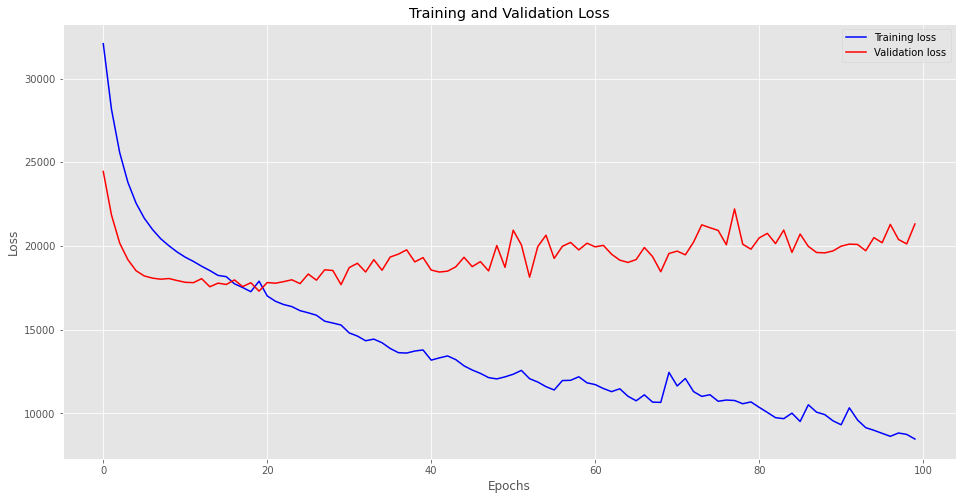

Epoch 1/100
103/103 [==============================] - 25s 193ms/step - loss: 32080.7695 - mean_squared_error: 32080.7715 - mean_absolute_error: 67.3129 - val_loss: 24444.6211 - val_mean_squared_error: 24444.6211 - val_mean_absolute_error: 64.4872
Epoch 2/100
103/103 [==============================] - 19s 182ms/step - loss: 28162.9590 - mean_squared_error: 28162.9531 - mean_absolute_error: 64.4196 - val_loss: 21845.0508 - val_mean_squared_error: 21845.0488 - val_mean_absolute_error: 62.4753
Epoch 3/100
103/103 [==============================] - 19s 183ms/step - loss: 25577.0840 - mean_squared_error: 25577.0898 - mean_absolute_error: 62.4854 - val_loss: 20171.9004 - val_mean_squared_error: 20171.8965 - val_mean_absolute_error: 61.1458
Epoch 4/100
103/103 [==============================] - 19s 183ms/step - loss: 23799.6816 - mean_squared_error: 23799.6875 - mean_absolute_error: 61.2547 - val_loss: 19176.2910 - val_mean_squared_error: 19176.2910 - val_mean_absolute_error: 60.5797
Epoch 5/100
103/103 [==============================] - 19s 184ms/step - loss: 22552.3828 - mean_squared_error: 22552.3770 - mean_absolute_error: 60.6248 - val_loss: 18517.0195 - val_mean_squared_error: 18517.0176 - val_mean_absolute_error: 60.3730
Epoch 6/100
103/103 [==============================] - 19s 183ms/step - loss: 21655.0430 - mean_squared_error: 21655.0410 - mean_absolute_error: 60.3317 - val_loss: 18205.1543 - val_mean_squared_error: 18205.1543 - val_mean_absolute_error: 60.2015
Epoch 7/100
103/103 [==============================] - 19s 182ms/step - loss: 20981.9570 - mean_squared_error: 20981.9531 - mean_absolute_error: 60.1115 - val_loss: 18075.1270 - val_mean_squared_error: 18075.1270 - val_mean_absolute_error: 60.6731
Epoch 8/100
103/103 [==============================] - 19s 182ms/step - loss: 20429.6641 - mean_squared_error: 20429.6621 - mean_absolute_error: 59.8430 - val_loss: 18010.9727 - val_mean_squared_error: 18010.9707 - val_mean_absolute_error: 60.8965
Epoch 9/100
103/103 [==============================] - 19s 180ms/step - loss: 20011.9258 - mean_squared_error: 20011.9238 - mean_absolute_error: 59.6013 - val_loss: 18051.4883 - val_mean_squared_error: 18051.4902 - val_mean_absolute_error: 61.4623
Epoch 10/100
103/103 [==============================] - 19s 181ms/step - loss: 19639.2402 - mean_squared_error: 19639.2363 - mean_absolute_error: 59.3513 - val_loss: 17932.5352 - val_mean_squared_error: 17932.5352 - val_mean_absolute_error: 61.1275
Epoch 11/100
103/103 [==============================] - 19s 181ms/step - loss: 19325.1387 - mean_squared_error: 19325.1367 - mean_absolute_error: 59.1686 - val_loss: 17825.2930 - val_mean_squared_error: 17825.2930 - val_mean_absolute_error: 61.2476
Epoch 12/100
103/103 [==============================] - 19s 180ms/step - loss: 19071.9590 - mean_squared_error: 19071.9590 - mean_absolute_error: 58.9423 - val_loss: 17805.7461 - val_mean_squared_error: 17805.7461 - val_mean_absolute_error: 60.7289
Epoch 13/100
103/103 [==============================] - 19s 181ms/step - loss: 18784.5527 - mean_squared_error: 18784.5586 - mean_absolute_error: 58.6352 - val_loss: 18041.6582 - val_mean_squared_error: 18041.6582 - val_mean_absolute_error: 61.6153
Epoch 14/100
103/103 [==============================] - 19s 181ms/step - loss: 18525.7891 - mean_squared_error: 18525.7871 - mean_absolute_error: 58.3488 - val_loss: 17558.5293 - val_mean_squared_error: 17558.5273 - val_mean_absolute_error: 60.4959
Epoch 15/100
103/103 [==============================] - 19s 180ms/step - loss: 18236.2754 - mean_squared_error: 18236.2773 - mean_absolute_error: 57.8997 - val_loss: 17775.4434 - val_mean_squared_error: 17775.4434 - val_mean_absolute_error: 61.2599
Epoch 16/100
103/103 [==============================] - 18s 179ms/step - loss: 18162.7520 - mean_squared_error: 18162.7500 - mean_absolute_error: 57.8089 - val_loss: 17694.9141 - val_mean_squared_error: 17694.9121 - val_mean_absolute_error: 60.5604
Epoch 17/100
103/103 [==============================] - 19s 181ms/step - loss: 17737.3223 - mean_squared_error: 17737.3242 - mean_absolute_error: 57.0741 - val_loss: 17968.4707 - val_mean_squared_error: 17968.4707 - val_mean_absolute_error: 60.8930
Epoch 18/100
103/103 [==============================] - 19s 181ms/step - loss: 17513.0977 - mean_squared_error: 17513.1016 - mean_absolute_error: 56.6903 - val_loss: 17569.7227 - val_mean_squared_error: 17569.7227 - val_mean_absolute_error: 59.4663
Epoch 19/100
103/103 [==============================] - 19s 182ms/step - loss: 17264.9824 - mean_squared_error: 17264.9766 - mean_absolute_error: 56.1915 - val_loss: 17798.1855 - val_mean_squared_error: 17798.1875 - val_mean_absolute_error: 59.3169
Epoch 20/100
103/103 [==============================] - 19s 182ms/step - loss: 17892.2207 - mean_squared_error: 17892.2207 - mean_absolute_error: 56.9440 - val_loss: 17296.9805 - val_mean_squared_error: 17296.9785 - val_mean_absolute_error: 58.8967
Epoch 21/100
103/103 [==============================] - 19s 182ms/step - loss: 17011.3652 - mean_squared_error: 17011.3633 - mean_absolute_error: 55.7026 - val_loss: 17810.0938 - val_mean_squared_error: 17810.0938 - val_mean_absolute_error: 59.0603
Epoch 22/100
103/103 [==============================] - 19s 183ms/step - loss: 16691.4590 - mean_squared_error: 16691.4590 - mean_absolute_error: 55.0934 - val_loss: 17771.0664 - val_mean_squared_error: 17771.0645 - val_mean_absolute_error: 58.6251
Epoch 23/100
103/103 [==============================] - 19s 182ms/step - loss: 16497.4785 - mean_squared_error: 16497.4766 - mean_absolute_error: 54.7080 - val_loss: 17865.0371 - val_mean_squared_error: 17865.0352 - val_mean_absolute_error: 58.6992
Epoch 24/100
103/103 [==============================] - 19s 182ms/step - loss: 16374.2188 - mean_squared_error: 16374.2197 - mean_absolute_error: 54.6219 - val_loss: 17976.0918 - val_mean_squared_error: 17976.0918 - val_mean_absolute_error: 59.2825
Epoch 25/100
103/103 [==============================] - 19s 182ms/step - loss: 16130.5381 - mean_squared_error: 16130.5332 - mean_absolute_error: 54.1599 - val_loss: 17745.4609 - val_mean_squared_error: 17745.4629 - val_mean_absolute_error: 58.3939
Epoch 26/100
103/103 [==============================] - 19s 181ms/step - loss: 16003.3838 - mean_squared_error: 16003.3809 - mean_absolute_error: 53.9248 - val_loss: 18319.5098 - val_mean_squared_error: 18319.5137 - val_mean_absolute_error: 59.8606
Epoch 27/100
103/103 [==============================] - 19s 181ms/step - loss: 15858.1777 - mean_squared_error: 15858.1797 - mean_absolute_error: 53.6434 - val_loss: 17952.1758 - val_mean_squared_error: 17952.1758 - val_mean_absolute_error: 58.3693
Epoch 28/100
103/103 [==============================] - 19s 180ms/step - loss: 15504.4482 - mean_squared_error: 15504.4512 - mean_absolute_error: 53.0667 - val_loss: 18570.3613 - val_mean_squared_error: 18570.3594 - val_mean_absolute_error: 59.0445
Epoch 29/100
103/103 [==============================] - 19s 181ms/step - loss: 15391.5830 - mean_squared_error: 15391.5820 - mean_absolute_error: 52.8101 - val_loss: 18531.9648 - val_mean_squared_error: 18531.9648 - val_mean_absolute_error: 58.6024
Epoch 30/100
103/103 [==============================] - 19s 181ms/step - loss: 15272.7139 - mean_squared_error: 15272.7148 - mean_absolute_error: 52.5474 - val_loss: 17686.8379 - val_mean_squared_error: 17686.8359 - val_mean_absolute_error: 57.2252
Epoch 31/100
103/103 [==============================] - 19s 181ms/step - loss: 14800.8359 - mean_squared_error: 14800.8359 - mean_absolute_error: 51.7301 - val_loss: 18705.3672 - val_mean_squared_error: 18705.3652 - val_mean_absolute_error: 58.8797
Epoch 32/100
103/103 [==============================] - 19s 181ms/step - loss: 14613.0684 - mean_squared_error: 14613.0693 - mean_absolute_error: 51.4129 - val_loss: 18961.4902 - val_mean_squared_error: 18961.4902 - val_mean_absolute_error: 59.1264
Epoch 33/100
103/103 [==============================] - 19s 181ms/step - loss: 14333.7852 - mean_squared_error: 14333.7881 - mean_absolute_error: 50.8929 - val_loss: 18441.3262 - val_mean_squared_error: 18441.3281 - val_mean_absolute_error: 58.4297
Epoch 34/100
103/103 [==============================] - 19s 180ms/step - loss: 14430.8232 - mean_squared_error: 14430.8252 - mean_absolute_error: 50.9966 - val_loss: 19176.8848 - val_mean_squared_error: 19176.8867 - val_mean_absolute_error: 58.8690
Epoch 35/100
103/103 [==============================] - 19s 180ms/step - loss: 14214.6875 - mean_squared_error: 14214.6875 - mean_absolute_error: 50.6725 - val_loss: 18545.5508 - val_mean_squared_error: 18545.5488 - val_mean_absolute_error: 57.5716
Epoch 36/100
103/103 [==============================] - 19s 181ms/step - loss: 13871.0801 - mean_squared_error: 13871.0869 - mean_absolute_error: 50.0863 - val_loss: 19335.2891 - val_mean_squared_error: 19335.2871 - val_mean_absolute_error: 59.2422
Epoch 37/100
103/103 [==============================] - 19s 181ms/step - loss: 13621.1221 - mean_squared_error: 13621.1172 - mean_absolute_error: 49.7015 - val_loss: 19509.2598 - val_mean_squared_error: 19509.2617 - val_mean_absolute_error: 59.3506
Epoch 38/100
103/103 [==============================] - 19s 181ms/step - loss: 13597.8643 - mean_squared_error: 13597.8672 - mean_absolute_error: 49.6593 - val_loss: 19765.1797 - val_mean_squared_error: 19765.1758 - val_mean_absolute_error: 59.4919
Epoch 39/100
103/103 [==============================] - 19s 181ms/step - loss: 13718.8096 - mean_squared_error: 13718.8135 - mean_absolute_error: 49.8878 - val_loss: 19044.1816 - val_mean_squared_error: 19044.1816 - val_mean_absolute_error: 58.4675
Epoch 40/100
103/103 [==============================] - 19s 183ms/step - loss: 13784.1865 - mean_squared_error: 13784.1777 - mean_absolute_error: 49.9296 - val_loss: 19300.8789 - val_mean_squared_error: 19300.8789 - val_mean_absolute_error: 58.9506
Epoch 41/100
103/103 [==============================] - 19s 182ms/step - loss: 13175.6816 - mean_squared_error: 13175.6826 - mean_absolute_error: 48.9314 - val_loss: 18556.3574 - val_mean_squared_error: 18556.3555 - val_mean_absolute_error: 56.9844
Epoch 42/100
103/103 [==============================] - 19s 182ms/step - loss: 13310.7998 - mean_squared_error: 13310.7998 - mean_absolute_error: 49.0597 - val_loss: 18438.6016 - val_mean_squared_error: 18438.5996 - val_mean_absolute_error: 56.6112
Epoch 43/100
103/103 [==============================] - 19s 183ms/step - loss: 13426.5205 - mean_squared_error: 13426.5176 - mean_absolute_error: 49.4713 - val_loss: 18491.0586 - val_mean_squared_error: 18491.0566 - val_mean_absolute_error: 57.2963
Epoch 44/100
103/103 [==============================] - 19s 181ms/step - loss: 13205.2412 - mean_squared_error: 13205.2402 - mean_absolute_error: 48.9758 - val_loss: 18750.8496 - val_mean_squared_error: 18750.8477 - val_mean_absolute_error: 57.6858
Epoch 45/100
103/103 [==============================] - 19s 182ms/step - loss: 12835.4883 - mean_squared_error: 12835.4893 - mean_absolute_error: 48.2234 - val_loss: 19321.3340 - val_mean_squared_error: 19321.3340 - val_mean_absolute_error: 58.2235
Epoch 46/100
103/103 [==============================] - 19s 182ms/step - loss: 12585.8311 - mean_squared_error: 12585.8271 - mean_absolute_error: 47.8448 - val_loss: 18760.9629 - val_mean_squared_error: 18760.9590 - val_mean_absolute_error: 57.2194
Epoch 47/100
103/103 [==============================] - 19s 183ms/step - loss: 12384.7197 - mean_squared_error: 12384.7227 - mean_absolute_error: 47.4682 - val_loss: 19061.2285 - val_mean_squared_error: 19061.2285 - val_mean_absolute_error: 57.0938
Epoch 48/100
103/103 [==============================] - 19s 181ms/step - loss: 12132.2949 - mean_squared_error: 12132.2979 - mean_absolute_error: 46.9724 - val_loss: 18505.1934 - val_mean_squared_error: 18505.1934 - val_mean_absolute_error: 56.3706
Epoch 49/100
103/103 [==============================] - 19s 182ms/step - loss: 12053.7158 - mean_squared_error: 12053.7119 - mean_absolute_error: 46.8674 - val_loss: 20023.1816 - val_mean_squared_error: 20023.1816 - val_mean_absolute_error: 58.8903
Epoch 50/100
103/103 [==============================] - 19s 181ms/step - loss: 12176.3037 - mean_squared_error: 12176.3057 - mean_absolute_error: 46.9372 - val_loss: 18716.7344 - val_mean_squared_error: 18716.7363 - val_mean_absolute_error: 57.4478
Epoch 51/100
103/103 [==============================] - 19s 181ms/step - loss: 12332.7686 - mean_squared_error: 12332.7676 - mean_absolute_error: 47.2310 - val_loss: 20937.7188 - val_mean_squared_error: 20937.7188 - val_mean_absolute_error: 59.4592
Epoch 52/100
103/103 [==============================] - 19s 181ms/step - loss: 12562.4854 - mean_squared_error: 12562.4863 - mean_absolute_error: 47.5589 - val_loss: 20060.7988 - val_mean_squared_error: 20060.7969 - val_mean_absolute_error: 58.2376
Epoch 53/100
103/103 [==============================] - 19s 181ms/step - loss: 12066.1543 - mean_squared_error: 12066.1543 - mean_absolute_error: 46.6984 - val_loss: 18128.1816 - val_mean_squared_error: 18128.1836 - val_mean_absolute_error: 55.5280
Epoch 54/100
103/103 [==============================] - 19s 181ms/step - loss: 11867.9902 - mean_squared_error: 11867.9951 - mean_absolute_error: 46.3478 - val_loss: 19963.1133 - val_mean_squared_error: 19963.1152 - val_mean_absolute_error: 57.9322
Epoch 55/100
103/103 [==============================] - 19s 182ms/step - loss: 11590.5498 - mean_squared_error: 11590.5498 - mean_absolute_error: 45.8430 - val_loss: 20637.9609 - val_mean_squared_error: 20637.9609 - val_mean_absolute_error: 59.1162
Epoch 56/100
103/103 [==============================] - 19s 182ms/step - loss: 11392.7002 - mean_squared_error: 11392.7031 - mean_absolute_error: 45.4826 - val_loss: 19254.3164 - val_mean_squared_error: 19254.3164 - val_mean_absolute_error: 57.1039
Epoch 57/100
103/103 [==============================] - 19s 183ms/step - loss: 11956.6201 - mean_squared_error: 11956.6182 - mean_absolute_error: 46.3920 - val_loss: 19977.2832 - val_mean_squared_error: 19977.2812 - val_mean_absolute_error: 58.3818
Epoch 58/100
103/103 [==============================] - 19s 182ms/step - loss: 11969.3350 - mean_squared_error: 11969.3350 - mean_absolute_error: 46.5943 - val_loss: 20206.3438 - val_mean_squared_error: 20206.3418 - val_mean_absolute_error: 58.5801
Epoch 59/100
103/103 [==============================] - 19s 183ms/step - loss: 12182.3906 - mean_squared_error: 12182.3945 - mean_absolute_error: 46.7737 - val_loss: 19760.4941 - val_mean_squared_error: 19760.4941 - val_mean_absolute_error: 57.8694
Epoch 60/100
103/103 [==============================] - 19s 182ms/step - loss: 11821.2041 - mean_squared_error: 11821.2021 - mean_absolute_error: 46.1361 - val_loss: 20160.3906 - val_mean_squared_error: 20160.3867 - val_mean_absolute_error: 58.0245
Epoch 61/100
103/103 [==============================] - 19s 183ms/step - loss: 11714.6387 - mean_squared_error: 11714.6387 - mean_absolute_error: 45.9607 - val_loss: 19942.9355 - val_mean_squared_error: 19942.9375 - val_mean_absolute_error: 57.2239
Epoch 62/100
103/103 [==============================] - 19s 183ms/step - loss: 11480.5898 - mean_squared_error: 11480.5908 - mean_absolute_error: 45.6200 - val_loss: 20032.8477 - val_mean_squared_error: 20032.8457 - val_mean_absolute_error: 57.9992
Epoch 63/100
103/103 [==============================] - 19s 182ms/step - loss: 11293.5566 - mean_squared_error: 11293.5537 - mean_absolute_error: 45.2366 - val_loss: 19503.0098 - val_mean_squared_error: 19503.0078 - val_mean_absolute_error: 56.8746
Epoch 64/100
103/103 [==============================] - 19s 182ms/step - loss: 11465.3154 - mean_squared_error: 11465.3154 - mean_absolute_error: 45.6483 - val_loss: 19150.2500 - val_mean_squared_error: 19150.2500 - val_mean_absolute_error: 56.9109
Epoch 65/100
103/103 [==============================] - 19s 184ms/step - loss: 11017.3418 - mean_squared_error: 11017.3389 - mean_absolute_error: 44.7768 - val_loss: 19012.2402 - val_mean_squared_error: 19012.2402 - val_mean_absolute_error: 56.3794
Epoch 66/100
103/103 [==============================] - 19s 183ms/step - loss: 10748.1338 - mean_squared_error: 10748.1328 - mean_absolute_error: 44.2888 - val_loss: 19185.2383 - val_mean_squared_error: 19185.2402 - val_mean_absolute_error: 57.0906
Epoch 67/100
103/103 [==============================] - 19s 182ms/step - loss: 11102.6602 - mean_squared_error: 11102.6592 - mean_absolute_error: 44.9879 - val_loss: 19905.5039 - val_mean_squared_error: 19905.5039 - val_mean_absolute_error: 58.0110
Epoch 68/100
103/103 [==============================] - 19s 184ms/step - loss: 10666.4961 - mean_squared_error: 10666.4980 - mean_absolute_error: 44.1587 - val_loss: 19360.7188 - val_mean_squared_error: 19360.7168 - val_mean_absolute_error: 56.8495
Epoch 69/100
103/103 [==============================] - 19s 183ms/step - loss: 10651.4551 - mean_squared_error: 10651.4580 - mean_absolute_error: 44.0972 - val_loss: 18457.7422 - val_mean_squared_error: 18457.7402 - val_mean_absolute_error: 56.1316
Epoch 70/100
103/103 [==============================] - 19s 183ms/step - loss: 12443.8271 - mean_squared_error: 12443.8301 - mean_absolute_error: 47.3079 - val_loss: 19547.0488 - val_mean_squared_error: 19547.0488 - val_mean_absolute_error: 56.9127
Epoch 71/100
103/103 [==============================] - 19s 183ms/step - loss: 11633.0400 - mean_squared_error: 11633.0420 - mean_absolute_error: 45.8936 - val_loss: 19687.5488 - val_mean_squared_error: 19687.5449 - val_mean_absolute_error: 57.9145
Epoch 72/100
103/103 [==============================] - 19s 181ms/step - loss: 12078.2256 - mean_squared_error: 12078.2246 - mean_absolute_error: 46.6362 - val_loss: 19467.2441 - val_mean_squared_error: 19467.2461 - val_mean_absolute_error: 57.3837
Epoch 73/100
103/103 [==============================] - 19s 185ms/step - loss: 11296.0479 - mean_squared_error: 11296.0469 - mean_absolute_error: 45.3202 - val_loss: 20226.4648 - val_mean_squared_error: 20226.4648 - val_mean_absolute_error: 58.0453
Epoch 74/100
103/103 [==============================] - 19s 184ms/step - loss: 11010.0234 - mean_squared_error: 11010.0254 - mean_absolute_error: 44.7340 - val_loss: 21259.4863 - val_mean_squared_error: 21259.4844 - val_mean_absolute_error: 58.8673
Epoch 75/100
103/103 [==============================] - 19s 182ms/step - loss: 11108.4297 - mean_squared_error: 11108.4297 - mean_absolute_error: 44.8930 - val_loss: 21084.5273 - val_mean_squared_error: 21084.5254 - val_mean_absolute_error: 58.5989
Epoch 76/100
103/103 [==============================] - 19s 181ms/step - loss: 10718.2090 - mean_squared_error: 10718.2109 - mean_absolute_error: 44.2656 - val_loss: 20925.8379 - val_mean_squared_error: 20925.8398 - val_mean_absolute_error: 58.6537
Epoch 77/100
103/103 [==============================] - 19s 183ms/step - loss: 10791.2441 - mean_squared_error: 10791.2441 - mean_absolute_error: 44.3571 - val_loss: 20070.7051 - val_mean_squared_error: 20070.7051 - val_mean_absolute_error: 57.7140
Epoch 78/100
103/103 [==============================] - 19s 182ms/step - loss: 10764.0488 - mean_squared_error: 10764.0488 - mean_absolute_error: 44.4348 - val_loss: 22208.5527 - val_mean_squared_error: 22208.5508 - val_mean_absolute_error: 59.8792
Epoch 79/100
103/103 [==============================] - 19s 183ms/step - loss: 10571.0410 - mean_squared_error: 10571.0400 - mean_absolute_error: 43.9991 - val_loss: 20100.1270 - val_mean_squared_error: 20100.1289 - val_mean_absolute_error: 57.4533
Epoch 80/100
103/103 [==============================] - 19s 181ms/step - loss: 10678.4004 - mean_squared_error: 10678.4004 - mean_absolute_error: 44.2338 - val_loss: 19802.3379 - val_mean_squared_error: 19802.3379 - val_mean_absolute_error: 57.3260
Epoch 81/100
103/103 [==============================] - 19s 182ms/step - loss: 10357.7959 - mean_squared_error: 10357.7959 - mean_absolute_error: 43.6248 - val_loss: 20475.1445 - val_mean_squared_error: 20475.1445 - val_mean_absolute_error: 58.1474
Epoch 82/100
103/103 [==============================] - 19s 182ms/step - loss: 10051.6533 - mean_squared_error: 10051.6553 - mean_absolute_error: 42.9980 - val_loss: 20749.7539 - val_mean_squared_error: 20749.7559 - val_mean_absolute_error: 58.6080
Epoch 83/100
103/103 [==============================] - 19s 181ms/step - loss: 9737.1484 - mean_squared_error: 9737.1494 - mean_absolute_error: 42.4217 - val_loss: 20137.2070 - val_mean_squared_error: 20137.2090 - val_mean_absolute_error: 57.6540
Epoch 84/100
103/103 [==============================] - 19s 181ms/step - loss: 9678.6367 - mean_squared_error: 9678.6348 - mean_absolute_error: 42.3078 - val_loss: 20945.0410 - val_mean_squared_error: 20945.0410 - val_mean_absolute_error: 58.7772
Epoch 85/100
103/103 [==============================] - 19s 181ms/step - loss: 10008.2197 - mean_squared_error: 10008.2197 - mean_absolute_error: 42.9717 - val_loss: 19611.2891 - val_mean_squared_error: 19611.2891 - val_mean_absolute_error: 56.7919
Epoch 86/100
103/103 [==============================] - 19s 181ms/step - loss: 9511.1748 - mean_squared_error: 9511.1787 - mean_absolute_error: 42.0640 - val_loss: 20707.9492 - val_mean_squared_error: 20707.9473 - val_mean_absolute_error: 58.8021
Epoch 87/100
103/103 [==============================] - 19s 181ms/step - loss: 10507.7324 - mean_squared_error: 10507.7314 - mean_absolute_error: 44.0947 - val_loss: 19970.4258 - val_mean_squared_error: 19970.4219 - val_mean_absolute_error: 57.3292
Epoch 88/100
103/103 [==============================] - 19s 181ms/step - loss: 10067.3984 - mean_squared_error: 10067.3965 - mean_absolute_error: 43.1105 - val_loss: 19606.2148 - val_mean_squared_error: 19606.2148 - val_mean_absolute_error: 56.9907
Epoch 89/100
103/103 [==============================] - 19s 181ms/step - loss: 9922.5107 - mean_squared_error: 9922.5137 - mean_absolute_error: 42.8036 - val_loss: 19582.8828 - val_mean_squared_error: 19582.8848 - val_mean_absolute_error: 56.4204
Epoch 90/100
103/103 [==============================] - 19s 181ms/step - loss: 9553.0801 - mean_squared_error: 9553.0791 - mean_absolute_error: 42.0761 - val_loss: 19698.3340 - val_mean_squared_error: 19698.3320 - val_mean_absolute_error: 56.3732
Epoch 91/100
103/103 [==============================] - 19s 181ms/step - loss: 9312.8486 - mean_squared_error: 9312.8486 - mean_absolute_error: 41.6124 - val_loss: 19983.1406 - val_mean_squared_error: 19983.1406 - val_mean_absolute_error: 56.9559
Epoch 92/100
103/103 [==============================] - 19s 181ms/step - loss: 10327.2109 - mean_squared_error: 10327.2090 - mean_absolute_error: 43.3202 - val_loss: 20106.2148 - val_mean_squared_error: 20106.2168 - val_mean_absolute_error: 57.2413
Epoch 93/100
103/103 [==============================] - 19s 180ms/step - loss: 9599.9102 - mean_squared_error: 9599.9082 - mean_absolute_error: 42.1143 - val_loss: 20087.3164 - val_mean_squared_error: 20087.3164 - val_mean_absolute_error: 57.4545
Epoch 94/100
103/103 [==============================] - 19s 182ms/step - loss: 9141.5381 - mean_squared_error: 9141.5361 - mean_absolute_error: 41.2761 - val_loss: 19711.8828 - val_mean_squared_error: 19711.8828 - val_mean_absolute_error: 56.7519
Epoch 95/100
103/103 [==============================] - 19s 182ms/step - loss: 8982.8672 - mean_squared_error: 8982.8662 - mean_absolute_error: 40.9631 - val_loss: 20495.0527 - val_mean_squared_error: 20495.0527 - val_mean_absolute_error: 57.4734
Epoch 96/100
103/103 [==============================] - 19s 182ms/step - loss: 8801.9814 - mean_squared_error: 8801.9834 - mean_absolute_error: 40.6012 - val_loss: 20190.2754 - val_mean_squared_error: 20190.2754 - val_mean_absolute_error: 57.3014
Epoch 97/100
103/103 [==============================] - 19s 183ms/step - loss: 8624.6602 - mean_squared_error: 8624.6582 - mean_absolute_error: 40.2520 - val_loss: 21283.2246 - val_mean_squared_error: 21283.2227 - val_mean_absolute_error: 58.2507
Epoch 98/100
103/103 [==============================] - 19s 182ms/step - loss: 8823.6191 - mean_squared_error: 8823.6201 - mean_absolute_error: 40.5848 - val_loss: 20382.6133 - val_mean_squared_error: 20382.6191 - val_mean_absolute_error: 57.5872
Epoch 99/100
103/103 [==============================] - 19s 181ms/step - loss: 8737.8174 - mean_squared_error: 8737.8135 - mean_absolute_error: 40.4979 - val_loss: 20118.5371 - val_mean_squared_error: 20118.5371 - val_mean_absolute_error: 56.9794
Epoch 100/100
103/103 [==============================] - 19s 181ms/step - loss: 8462.0420 - mean_squared_error: 8462.0420 - mean_absolute_error: 39.8746 - val_loss: 21310.1094 - val_mean_squared_error: 21310.1113 - val_mean_absolute_error: 58.5072
WARNING:absl:Function `_wrapped_model` contains input name(s) Input-Layer with unsupported characters which will be renamed to input_layer in the SavedModel.
WARNING:absl:Found untraced functions such as gru_cell_31_layer_call_fn, gru_cell_31_layer_call_and_return_conditional_losses, gru_cell_32_layer_call_fn, gru_cell_32_layer_call_and_return_conditional_losses, gru_cell_34_layer_call_fn while saving (showing 5 of 8). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: saved_models/model_ep1000_b256_seq2_2022-07-13 13:46:24/assets
INFO:tensorflow:Assets written to: saved_models/model_ep1000_b256_seq2_2022-07-13 13:46:24/assets

Accuracy:  49.1086%

 	 RMSE: 28.011332108871613, MAE: 21.14785314882822

 --- Overall Score --- 
	24.579592628849916
    
    20 epoch
    Accuracy:  45.6750%

 	 RMSE: 23.901064264865575, MAE: 17.199610569519734

 --- Overall Score --- 
	20.550337417192654

features = ['TurbID', 'Day','locX', 'locY', 'TimeX', 'TimeY', 'DayX', 'DayY','Etmp_abs','RPM', 'WspdX', 'WspdY', 'WdirX', 'WdirY','Wspd', 'Wspd_cube',
       'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR', 'Prtv', 'Patv']
       
       
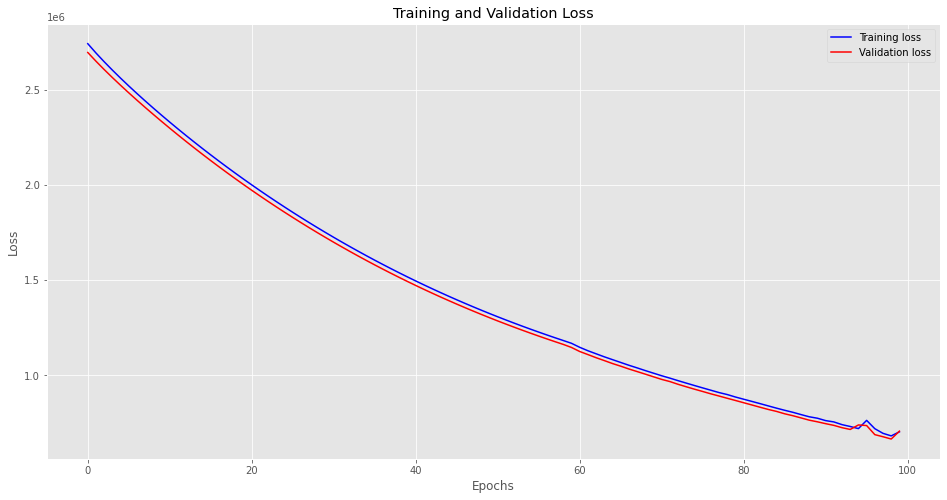


-------------------- Model Summary --------------------
Model: "GRU-Model"

 Hidden-GRU-Encoder-Layer (B  (None, 512)              428544    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 21)          10773     
 ed)                                                             
                                                                 
=================================================================
Total params: 1,622,037
Trainable params: 1,622,037
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Too many parameters to print but you can use the code provided if needed

-------------------- Evaluation on Training Data --------------------
Final loss : 703546.3125
Final mean_squared_error : 703546.3125
Final mean_absolute_error : 238.30673217773438
Final val_loss : 707137.6875
Final val_mean_squared_error : 707137.6875
Final val_mean_absolute_error : 240.07861328125

-------------------- Evaluation on Test Data --------------------
155/155 [==============================] - 14s 90ms/step - loss: 707137.8125 - mean_squared_error: 707137.7500 - mean_absolute_error: 240.0785

-------------------- Accuracy and Score --------------------
5/5 [==============================] - 2s 74ms/step
Accuracy:  57.8457%

 	 RMSE: 35.369783263166255, MAE: 32.399832221552145

 --- Overall Score --- 
	33.8848077423592
    
    
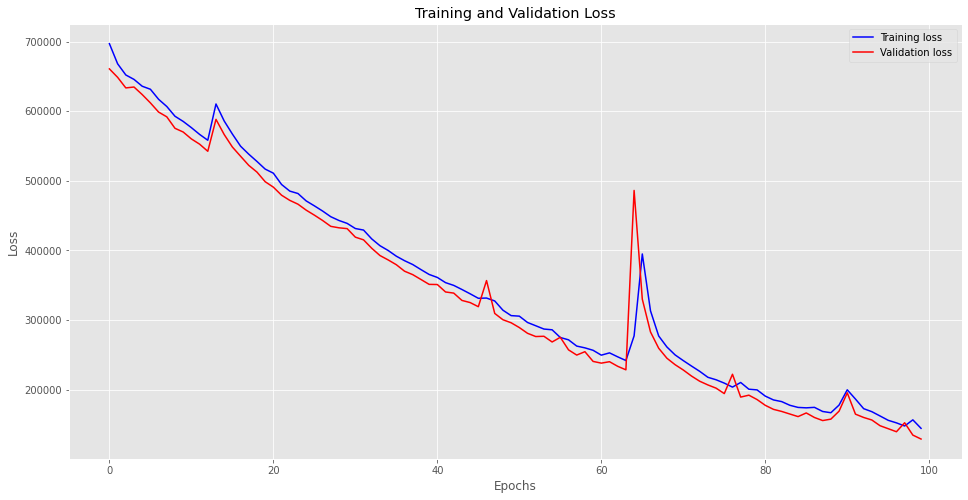
    
    -------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________

 Hidden-GRU-Encoder-Layer (B  (None, 512)              428544    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 21)          10773     
 ed)                                                             
                                                                 
=================================================================
Total params: 1,622,037
Trainable params: 1,622,037
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Too many parameters to print but you can use the code provided if needed

-------------------- Evaluation on Training Data --------------------
Final loss : 144308.625
Final mean_squared_error : 144308.59375
Final mean_absolute_error : 115.59717559814453
Final val_loss : 128938.703125
Final val_mean_squared_error : 128938.703125
Final val_mean_absolute_error : 113.26066589355469

-------------------- Evaluation on Test Data --------------------
155/155 [==============================] - 8s 38ms/step - loss: 128938.7422 - mean_squared_error: 128938.7031 - mean_absolute_error: 113.2606

-------------------- Accuracy and Score --------------------
5/5 [==============================] - 1s 32ms/step

Accuracy:  58.1931%

 	 RMSE: 35.89932208537439, MAE: 33.020675346645774

 --- Overall Score --- 
	34.459998716010084
    
    
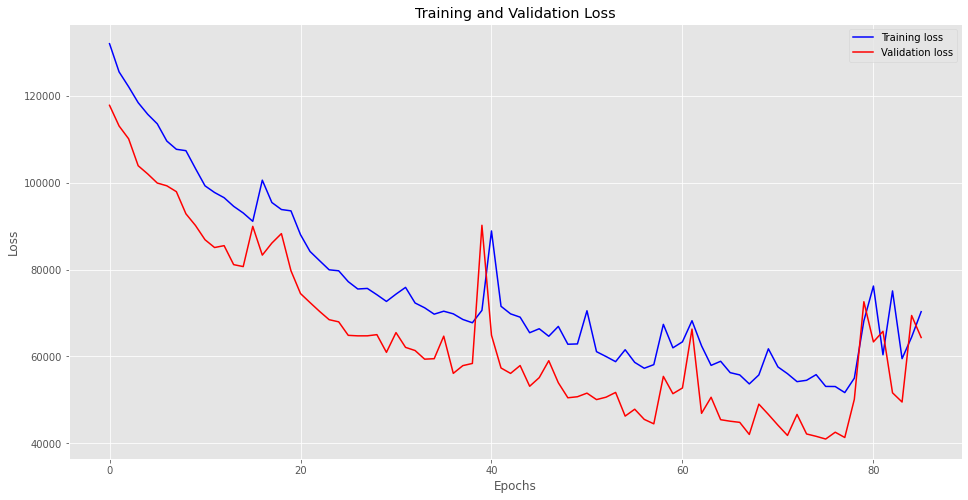


-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Hidden-GRU-Encoder-Layer (B  (None, 512)              428544    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 21)          10773     
 ed)                                                             
                                                                 
=================================================================
Total params: 1,622,037
Trainable params: 1,622,037
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Too many parameters to print but you can use the code provided if needed

-------------------- Evaluation on Training Data --------------------
Final loss : 70310.25
Final mean_squared_error : 70310.2421875
Final mean_absolute_error : 86.58228302001953
Final val_loss : 64364.625
Final val_mean_squared_error : 64364.62109375
Final val_mean_absolute_error : 89.93852996826172

-------------------- Evaluation on Test Data --------------------
155/155 [==============================] - 6s 38ms/step - loss: 41005.8828 - mean_squared_error: 41005.8945 - mean_absolute_error: 73.6495

-------------------- Accuracy and Score --------------------
5/5 [==============================] - 0s 31ms/step
Accuracy:  58.0793%

 	 RMSE: 35.60623692365765, MAE: 32.724239186385546

 --- Overall Score --- 
	34.1652380550216

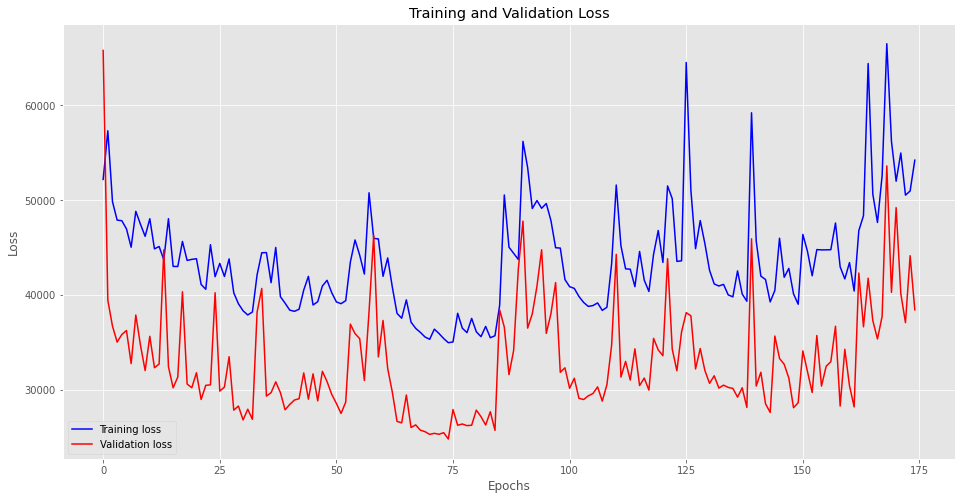


-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Hidden-GRU-Encoder-Layer (B  (None, 512)              428544    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 21)          10773     
 ed)                                                             
                                                                 
=================================================================
Total params: 1,622,037
Trainable params: 1,622,037
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Too many parameters to print but you can use the code provided if needed

-------------------- Evaluation on Training Data --------------------
Final loss : 54230.203125
Final mean_squared_error : 54230.2265625
Final mean_absolute_error : 77.212890625
Final val_loss : 38441.1328125
Final val_mean_squared_error : 38441.125
Final val_mean_absolute_error : 72.4822769165039

-------------------- Evaluation on Test Data --------------------
155/155 [==============================] - 6s 38ms/step - loss: 24805.4199 - mean_squared_error: 24805.4336 - mean_absolute_error: 58.4912

-------------------- Accuracy and Score --------------------
5/5 [==============================] - 0s 32ms/step
Accuracy:  58.0543%

 	 RMSE: 35.54028785618236, MAE: 32.65800258938302

 --- Overall Score --- 
	34.09914522278269

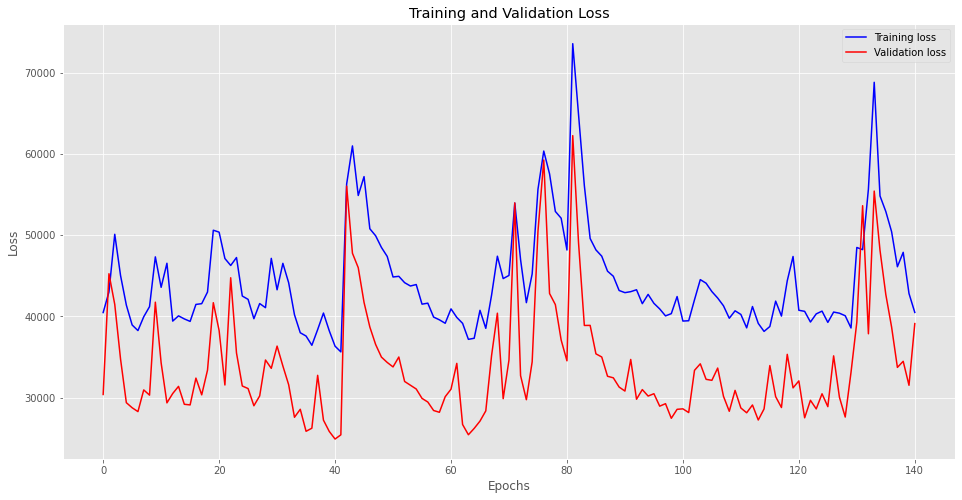


-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Hidden-GRU-Encoder-Layer (B  (None, 512)              428544    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 21)          10773     
 ed)                                                             
                                                                 
=================================================================
Total params: 1,622,037
Trainable params: 1,622,037
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Too many parameters to print but you can use the code provided if needed

-------------------- Evaluation on Training Data --------------------
Final loss : 63276.49609375
Final mean_squared_error : 63276.48046875
Final mean_absolute_error : 84.18006134033203
Final val_loss : 62316.578125
Final val_mean_squared_error : 62316.5859375
Final val_mean_absolute_error : 90.48474884033203

-------------------- Evaluation on Test Data --------------------
155/155 [==============================] - 6s 37ms/step - loss: 24063.5508 - mean_squared_error: 24063.5352 - mean_absolute_error: 58.0539

-------------------- Accuracy and Score --------------------
5/5 [==============================] - 0s 31ms/step
Accuracy:  58.1650%

 	 RMSE: 35.78297389206584, MAE: 32.93105096308261

 --- Overall Score --- 
	34.357012427574226

 ## features = ['TurbID','Day', 'WspdY_abs', 'Itmp', 'WdirX', 'WspdX_abs', 'Patan',
       'Prtv', 'TSR',  'Pab',
       'P_max', 'Wspd_cube', 'Wspd', 'WspdX', 'RPM',
       'Papt', 'Patv']
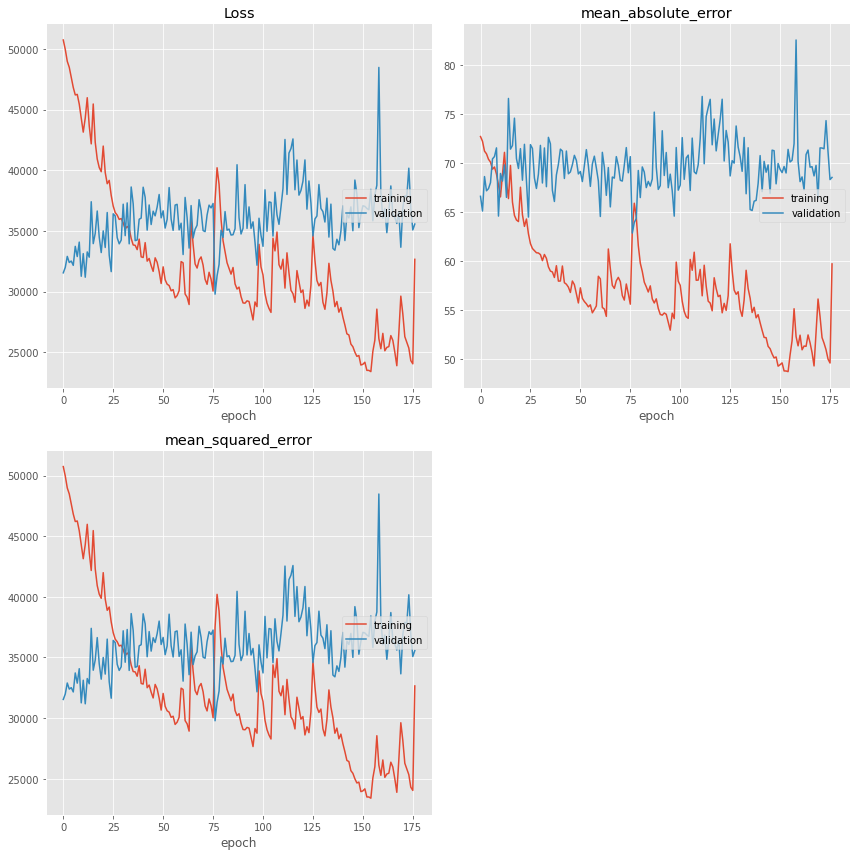


-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Hidden-GRU-Encoder-Layer (B  (None, 512)              419328    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 15)          7695      
 ed)                                                             
                                                                 
=================================================================
Total params: 1,609,743
Trainable params: 1,609,743
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Too many parameters to print but you can use the code provided if needed

-------------------- Evaluation on Training Data --------------------
Final loss : 32653.677734375
Final mean_squared_error : 32653.6875
Final mean_absolute_error : 59.70053482055664
Final val_loss : 35564.8125
Final val_mean_squared_error : 35564.81640625
Final val_mean_absolute_error : 68.52515411376953

-------------------- Evaluation on Test Data --------------------
155/155 [==============================] - 6s 39ms/step - loss: 29782.2734 - mean_squared_error: 29782.2598 - mean_absolute_error: 62.8444

-------------------- Accuracy and Score --------------------
5/5 [==============================] - 2s 32ms/step
Accuracy:  55.0360%

 	 RMSE: 399.5539085862987, MAE: 300.3371543627951

 --- Overall Score --- 
	349.9455314745469